# 《自然语言处理入门》随书代码

欢迎阅读《自然语言处理入门》随书代码，在开始之前，请运行下面的脚本来自动配置环境：

In [1]:
import os
import sys

folders = os.path.abspath(__file__ if '__file__' in globals() else '.').split(os.path.sep)
if 'tests' not in folders:
    if os.name == 'nt':
        print('找不到tests文件夹，请下载https://github.com/hankcs/pyhanlp/archive/master.zip解压后进入pyhanlp-master目录运行')
        exit(1)
    else:
        !wget https://github.com/hankcs/pyhanlp/archive/master.zip && unzip -q master.zip && pip install -e pyhanlp-master
        os.chdir('pyhanlp-master/tests')
        folders = os.path.abspath('.').split('/')
    
index = folders.index('tests')
# 将tests放入path中，并且排除IPython/extensions下面的tests
sys.path = [os.path.sep.join(folders[:index])] + [x for x in sys.path if 'IPython' not in x]
from tests.test_utility import ensure_data

# 我们作图要显示中文，但有的机器上没有中文字体，所以这里安装一下
import matplotlib
from matplotlib import pyplot as plt
fontpath = ensure_data('SimHei.ttf', 'https://github.com/StellarCN/scp_zh/raw/master/fonts/SimHei.ttf')
myfont = matplotlib.font_manager.FontProperties(fname=fontpath)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
print('环境配置完毕，请开始你的NLP之旅！')

环境配置完毕，请开始你的NLP之旅！


## 第01章

### tests/book/ch01/hello_word.py

In [2]:
# Author: hankcs
# Date: 2019-03-21 21:22
# 《自然语言处理入门》1.6 开源工具
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *


def main():
    HanLP.Config.enableDebug()
    #  为了避免你等得无聊，开启调试模式说点什么:-)
    print(HanLP.segment("王国维和服务员"))


if __name__ == '__main__':
    main()

[王国维/nr, 和/cc, 服务员/nnt]


## 第02章

### tests/book/ch02/evaluate_cws.py

In [3]:
# Author：hankcs
# Date: 2018-06-02 22:53
# 《自然语言处理入门》2.9 准确率评测
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import re
from pyhanlp import *
from tests.test_utility import ensure_data


def to_region(segmentation: str) -> list:
    """
    将分词结果转换为区间
    :param segmentation: 商品 和 服务
    :return: [(0, 2), (2, 3), (3, 5)]
    """
    region = []
    start = 0
    for word in re.compile("\\s+").split(segmentation.strip()):
        end = start + len(word)
        region.append((start, end))
        start = end
    return region


def prf(gold: str, pred: str, dic) -> tuple:
    """
    计算P、R、F1
    :param gold: 标准答案文件，比如“商品 和 服务”
    :param pred: 分词结果文件，比如“商品 和服 务”
    :param dic: 词典
    :return: (P, R, F1, OOV_R, IV_R)
    """
    A_size, B_size, A_cap_B_size, OOV, IV, OOV_R, IV_R = 0, 0, 0, 0, 0, 0, 0
    with open(gold, encoding='utf-8') as gd, open(pred, encoding='utf-8') as pd:
        for g, p in zip(gd, pd):
            A, B = set(to_region(g)), set(to_region(p))
            A_size += len(A)
            B_size += len(B)
            A_cap_B_size += len(A & B)
            text = re.sub("\\s+", "", g)
            for (start, end) in A:
                word = text[start: end]
                if dic.containsKey(word):
                    IV += 1
                else:
                    OOV += 1

            for (start, end) in A & B:
                word = text[start: end]
                if dic.containsKey(word):
                    IV_R += 1
                else:
                    OOV_R += 1
    p, r = A_cap_B_size / B_size * 100, A_cap_B_size / A_size * 100
    return p, r, 2 * p * r / (p + r), OOV_R / OOV * 100, IV_R / IV * 100


if __name__ == '__main__':
    print(to_region('商品 和 服务'))

    sighan05 = ensure_data('icwb2-data', 'http://sighan.cs.uchicago.edu/bakeoff2005/data/icwb2-data.zip')
    msr_dict = os.path.join(sighan05, 'gold', 'msr_training_words.utf8')
    msr_test = os.path.join(sighan05, 'testing', 'msr_test.utf8')
    msr_output = os.path.join(sighan05, 'testing', 'msr_output.txt')
    msr_gold = os.path.join(sighan05, 'gold', 'msr_test_gold.utf8')

    DoubleArrayTrieSegment = JClass('com.hankcs.hanlp.seg.Other.DoubleArrayTrieSegment')
    segment = DoubleArrayTrieSegment([msr_dict]).enablePartOfSpeechTagging(True)
    with open(msr_gold, encoding='utf-8') as test, open(msr_output, 'w', encoding='utf-8') as output:
        for line in test:
            output.write("  ".join(term.word for term in segment.seg(re.sub("\\s+", "", line))))
            output.write("\n")
    print("P:%.2f R:%.2f F1:%.2f OOV-R:%.2f IV-R:%.2f" % prf(msr_gold, msr_output, segment.trie))

[(0, 2), (2, 3), (3, 5)]
P:91.80 R:95.69 F1:93.71 OOV-R:2.58 IV-R:98.22


### tests/book/ch02/dat.py

In [4]:
# Author：hankcs
# Date: 2018-05-26 21:16
# 《自然语言处理入门》2.5 双数组字典树
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *


class DoubleArrayTrie(object):
    def __init__(self, dic: dict) -> None:
        m = JClass('java.util.TreeMap')()
        for k, v in dic.items():
            m[k] = v
        DoubleArrayTrie = JClass('com.hankcs.hanlp.collection.trie.DoubleArrayTrie')
        dat = DoubleArrayTrie(m)
        self.base = dat.getBase()
        self.check = dat.getCheck()
        self.value = dat.getValueArray([''])

    @staticmethod
    def char_hash(c) -> int:
        return JClass('java.lang.Character')(c).hashCode()

    def transition(self, c, b) -> int:
        """
        状态转移
        :param c: 字符
        :param b: 初始状态
        :return: 转移后的状态，-1表示失败
        """
        p = self.base[b] + self.char_hash(c) + 1
        if self.base[b] == self.check[p]:
            return p
        else:
            return -1

    def __getitem__(self, key: str):
        b = 0
        for i in range(0, len(key)):  # len(key)次状态转移
            p = self.transition(key[i], b)
            if p != -1:
                b = p
            else:
                return None

        p = self.base[b]  # 按字符'\0'进行状态转移
        n = self.base[p]  # 查询base
        if p == self.check[p] and n < 0:  # 状态转移成功且对应词语结尾
            index = -n - 1  # 取得字典序
            return self.value[index]
        return None


if __name__ == '__main__':
    dic = {'自然': 'nature', '自然人': 'human', '自然语言': 'language', '自语': 'talk	to oneself', '入门': 'introduction'}
    dat = DoubleArrayTrie(dic)
    assert dat['自然'] == 'nature'
    assert dat['自然语言'] == 'language'
    assert dat['不存在'] is None
    assert dat['自然\0在'] is None

### tests/book/ch02/bidirectional_segment.py

In [5]:
# Author：hankcs
# Date: 2018-05-24 21:23
# 《自然语言处理入门》2.3.4 双向最长匹配
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from tests.book.ch02.backward_segment import backward_segment
from tests.book.ch02.forward_segment import forward_segment
from tests.book.ch02.utility import load_dictionary
import os
from pyhanlp import *
from pyhanlp.static import HANLP_DATA_PATH

def count_single_char(word_list: list):  # 统计单字成词的个数
    return sum(1 for word in word_list if len(word) == 1)


def bidirectional_segment(text, dic):
    f = forward_segment(text, dic)
    b = backward_segment(text, dic)
    if len(f) < len(b):                                  # 词数更少优先级更高
        return f
    elif len(f) > len(b):
        return b
    else:
        if count_single_char(f) < count_single_char(b):  # 单字更少优先级更高
            return f
        else:
            return b                                     # 都相等时逆向匹配优先级更高


if __name__ == '__main__':
    HanLP.Config.CoreDictionaryPath = os.path.join(HANLP_DATA_PATH, "dictionary/CoreNatureDictionary.txt")
    dic = load_dictionary()

    print(bidirectional_segment('研究生命起源', dic))

['研究', '生命', '起源']


### tests/book/ch02/utility.py

In [6]:
# Author：hankcs
# Date: 2018-05-24 22:11
# 《自然语言处理入门》2.2.2 词典的加载
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *


def load_dictionary():
    """
    加载HanLP中的mini词库
    :return: 一个set形式的词库
    """
    IOUtil = JClass('com.hankcs.hanlp.corpus.io.IOUtil')
    path = HanLP.Config.CoreDictionaryPath.replace('.txt', '.mini.txt')
    dic = IOUtil.loadDictionary([path])
    return set(dic.keySet())


if __name__ == '__main__':
    dic = load_dictionary()
    print(len(dic))
    print(list(dic)[0])

85584
青鸿


### tests/book/ch02/aho_corasick_double_array_trie.py

In [7]:
# Author：hankcs
# Date: 2018-05-28 18:10
# 《自然语言处理入门》2.7 基于双数组字典树的 AC 自动机
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *


def classic_demo():
    words = ["hers", "his", "she", "he"]
    map = JClass('java.util.TreeMap')()     # 创建TreeMap实例
    for word in words:
        map[word] = word.upper()            # 存放键值对
    trie = JClass('com.hankcs.hanlp.collection.AhoCorasick.AhoCorasickDoubleArrayTrie')(map)
    for hit in trie.parseText("ushers"):    # 遍历查询结果
        print("[%d:%d]=%s" % (hit.begin, hit.end, hit.value))


if __name__ == '__main__':
    classic_demo()

[1:4]=SHE
[2:4]=HE
[2:6]=HERS


### tests/book/ch02/zipf_law.py

[('，', 173173), ('的', 128146), ('。', 81757), ('、', 40695), ('在', 28445), ('了', 27103), ('和', 24398), ('是', 18068), ('”', 16867), ('“', 16686), ('一', 11503), ('有', 9905), ('对', 9654), ('为', 9516), ('中', 9444), ('上', 8408), ('不', 7222), ('这', 7198), ('与', 7197), ('他', 7062), ('就', 6485), ('人', 6338), ('到', 6316), ('等', 6008), ('：', 5988), ('发展', 5976), ('说', 5973), ('也', 5801), ('要', 5660), ('将', 5651)]


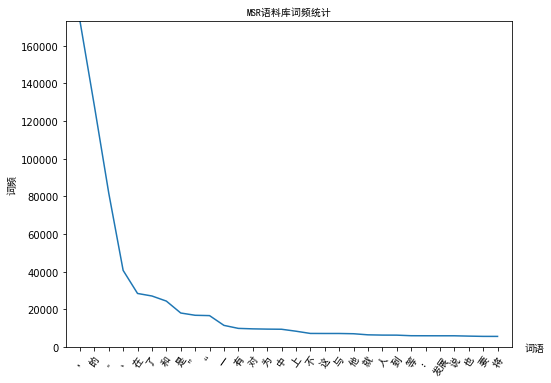

In [8]:
# Author：hankcs
# Date: 2018-06-01 09:53
# 《自然语言处理入门》2.1.2 词的性质——齐夫定律
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import os
from collections import Counter

import numpy as np

from tests.test_utility import ensure_data

sighan05 = ensure_data('icwb2-data', 'http://sighan.cs.uchicago.edu/bakeoff2005/data/icwb2-data.zip')
msr = os.path.join(sighan05, 'training', 'msr_training.utf8')

f = Counter()
with open(msr, encoding='utf-8') as src:
    for line in src:
        line = line.strip()
        for word in line.split('  '):
            # word = word.strip()
            # if len(word) < 2: continue
            f[word] += 1


def plot(token_counts, title='MSR语料库词频统计', ylabel='词频'):
    import matplotlib
    from matplotlib import pyplot as plt
    fontpath = ensure_data('SimHei.ttf', 'https://github.com/StellarCN/scp_zh/raw/master/fonts/SimHei.ttf')
    myfont = matplotlib.font_manager.FontProperties(fname=fontpath)
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    fig = plt.figure(
        figsize=(8, 6)
    )
    ax = fig.add_subplot(111)
    token_counts = list(zip(*token_counts))
    num_elements = np.arange(len(token_counts[0]))
    top_offset = max(token_counts[1]) + len(str(max(token_counts[1])))
    ax.set_title(title,fontproperties=myfont)
    ax.set_xlabel('词语',fontproperties=myfont)
    ax.set_ylabel(ylabel,fontproperties=myfont)
    ax.xaxis.set_label_coords(1.05, 0.015)
    ax.set_xticks(num_elements)
    ax.set_xticklabels(token_counts[0], rotation=55, verticalalignment='top',fontproperties=myfont)
    ax.set_ylim([0, top_offset])
    ax.set_xlim([-1, len(token_counts[0])])
    rects = ax.plot(num_elements, token_counts[1], linewidth=1.5)
    plt.show()


word_freq = f.most_common(30)
print(word_freq)
plot(word_freq)
# log_word_freq = []
# for w, f in word_freq:
#     log_word_freq.append((w, np.log(f)))
# plot(log_word_freq, ylabel='词频的对数')

### tests/book/ch02/demo_dat_segment.py

In [9]:
# Author：hankcs
# Date: 2018-05-29 09:48
# 《自然语言处理入门》2.8 HanLP 的词典分词实现
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *
from pyhanlp.static import HANLP_DATA_PATH
dict1 = HANLP_DATA_PATH + "/dictionary/CoreNatureDictionary.mini.txt"

HanLP.Config.ShowTermNature = False
segment = DoubleArrayTrieSegment(dict1)
print(segment.seg('江西鄱阳湖干枯，中国最大淡水湖变成大草原'))

dict2 = HANLP_DATA_PATH + "/dictionary/custom/上海地名.txt ns"
segment = DoubleArrayTrieSegment([dict1, dict2])
print(segment.seg('上海市虹口区大连西路550号SISU'))

segment.enablePartOfSpeechTagging(True)
HanLP.Config.ShowTermNature = True
print(segment.seg('上海市虹口区大连西路550号SISU'))

for term in segment.seg('上海市虹口区大连西路550号SISU'):
    print("单词:%s 词性:%s" % (term.word, term.nature))

[江西, 鄱阳湖, 干枯, ，, 中国, 最, 大, 淡水湖, 变成, 大, 草原]
[上海市, 虹口区, 大连西路, 5, 5, 0, 号, S, I, S, U]
[上海市/ns, 虹口区/ns, 大连西路/ns, 550/m, 号/q, SISU/nx]
单词:上海市 词性:ns
单词:虹口区 词性:ns
单词:大连西路 词性:ns
单词:550 词性:m
单词:号 词性:q
单词:SISU 词性:nx


### tests/book/ch02/backward_segment.py

In [10]:
# Author：hankcs
# Date: 2018-05-22 21:05
# 《自然语言处理入门》2.3.3 逆向最长匹配
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from tests.book.ch02.utility import load_dictionary


def backward_segment(text, dic):
    word_list = []
    i = len(text) - 1
    while i >= 0:                                   # 扫描位置作为终点
        longest_word = text[i]                      # 扫描位置的单字
        for j in range(0, i):                       # 遍历[0, i]区间作为待查询词语的起点
            word = text[j: i + 1]                   # 取出[j, i]区间作为待查询单词
            if word in dic:
                if len(word) > len(longest_word):   # 越长优先级越高
                    longest_word = word
                    break
        word_list.insert(0, longest_word)           # 逆向扫描，所以越先查出的单词在位置上越靠后
        i -= len(longest_word)
    return word_list


if __name__ == '__main__':
    dic = load_dictionary()

    print(backward_segment('研究生命起源', dic))

['研究', '生命', '起源']


### tests/book/ch02/speed_benchmark.py

In [11]:
# Author：hankcs
# Date: 2018-05-25 10:21
# 《自然语言处理入门》2.3.5 速度评测
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import time

from tests.book.ch02.backward_segment import backward_segment
from tests.book.ch02.bidirectional_segment import bidirectional_segment
from tests.book.ch02.forward_segment import forward_segment
from tests.book.ch02.utility import load_dictionary


def evaluate_speed(segment, text, dic):
    start_time = time.time()
    for i in range(pressure):
        segment(text, dic)
    elapsed_time = time.time() - start_time
    print('%.2f 万字/秒' % (len(text) * pressure / 10000 / elapsed_time))


if __name__ == '__main__':
    text = "江西鄱阳湖干枯，中国最大淡水湖变成大草原"
    pressure = 10000
    dic = load_dictionary()

    print('由于JPype调用开销巨大，以下速度显著慢于原生Java')
    evaluate_speed(forward_segment, text, dic)
    evaluate_speed(backward_segment, text, dic)
    evaluate_speed(bidirectional_segment, text, dic)

由于JPype调用开销巨大，以下速度显著慢于原生Java
59.70 万字/秒
62.65 万字/秒
28.66 万字/秒


### tests/book/ch02/aho_corasick.py

In [12]:
# Author：hankcs
# Date: 2018-05-28 15:22
# 《自然语言处理入门》2.6 AC 自动机
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *


def classic_demo():
    words = ["hers", "his", "she", "he"]
    Trie = JClass('com.hankcs.hanlp.algorithm.ahocorasick.trie.Trie')
    trie = Trie()
    for w in words:
        trie.addKeyword(w)

    for emit in trie.parseText("ushers"):
        print("[%d:%d]=%s" % (emit.getStart(), emit.getEnd(), emit.getKeyword()))


if __name__ == '__main__':
    classic_demo()

[2:3]=he
[1:3]=she
[2:5]=hers


### tests/book/ch02/fully_segment.py

In [13]:
# Author：hankcs
# Date: 2018-05-22 21:05
# 《自然语言处理入门》2.3.1 完全切分
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from tests.book.ch02.utility import load_dictionary


def fully_segment(text, dic):
    word_list = []
    for i in range(len(text)):                  # i 从 0 到text的最后一个字的下标遍历
        for j in range(i + 1, len(text) + 1):   # j 遍历[i + 1, len(text)]区间
            word = text[i:j]                    # 取出连续区间[i, j]对应的字符串
            if word in dic:                     # 如果在词典中，则认为是一个词
                word_list.append(word)
    return word_list


if __name__ == '__main__':
    dic = load_dictionary()

    print(fully_segment('商品和服务', dic))

['商', '商品', '品', '和', '和服', '服', '服务', '务']


### tests/book/ch02/trie.py

In [14]:
# Author：hankcs
# Date: 2018-05-25 17:25
# 《自然语言处理入门》2.4 字典树
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

class Node(object):
    def __init__(self, value) -> None:
        self._children = {}
        self._value = value

    def _add_child(self, char, value, overwrite=False):
        child = self._children.get(char)
        if child is None:
            child = Node(value)
            self._children[char] = child
        elif overwrite:
            child._value = value
        return child


class Trie(Node):
    def __init__(self) -> None:
        super().__init__(None)

    def __contains__(self, key):
        return self[key] is not None

    def __getitem__(self, key):
        state = self
        for char in key:
            state = state._children.get(char)
            if state is None:
                return None
        return state._value

    def __setitem__(self, key, value):
        state = self
        for i, char in enumerate(key):
            if i < len(key) - 1:
                state = state._add_child(char, None, False)
            else:
                state = state._add_child(char, value, True)


if __name__ == '__main__':
    trie = Trie()
    # 增
    trie['自然'] = 'nature'
    trie['自然人'] = 'human'
    trie['自然语言'] = 'language'
    trie['自语'] = 'talk	to oneself'
    trie['入门'] = 'introduction'
    assert '自然' in trie
    # 删
    trie['自然'] = None
    assert '自然' not in trie
    # 改
    trie['自然语言'] = 'human language'
    assert trie['自然语言'] == 'human language'
    # 查
    assert trie['入门'] == 'introduction'

### tests/book/ch02/forward_segment.py

In [15]:
# Author：hankcs
# Date: 2018-05-22 21:05
# 《自然语言处理入门》2.3.2 正向最长匹配
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from tests.book.ch02.utility import load_dictionary


def forward_segment(text, dic):
    word_list = []
    i = 0
    while i < len(text):
        longest_word = text[i]                      # 当前扫描位置的单字
        for j in range(i + 1, len(text) + 1):       # 所有可能的结尾
            word = text[i:j]                        # 从当前位置到结尾的连续字符串
            if word in dic:                         # 在词典中
                if len(word) > len(longest_word):   # 并且更长
                    longest_word = word             # 则更优先输出
        word_list.append(longest_word)              # 输出最长词
        i += len(longest_word)                      # 正向扫描
    return word_list


if __name__ == '__main__':
    dic = load_dictionary()

    print(forward_segment('就读北京大学', dic))
    print(forward_segment('研究生命起源', dic))

['就读', '北京大学']
['研究生', '命', '起源']


### tests/book/ch02/demo_acdat_segment.py

In [16]:
# Author：hankcs
# Date: 2018-05-29 13:51
# 《自然语言处理入门》2.8 HanLP 的词典分词实现
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *

HanLP.Config.ShowTermNature = False
segment = JClass('com.hankcs.hanlp.seg.Other.AhoCorasickDoubleArrayTrieSegment')(HanLP.Config.CoreDictionaryPath)
print(segment.seg("江西鄱阳湖干枯，中国最大淡水湖变成大草原"))

[江西, 鄱阳湖, 干枯, ，, 中国, 最大, 淡水湖, 变成, 大草原]


### tests/book/ch02/demo_stopwords.py

In [ ]:
# Author：hankcs
# Date: 2018-06-04 11:17
# 《自然语言处理入门》2.10.1 停用词过滤
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from jpype import JString

from pyhanlp import *


def load_from_file(path):
    """
    从词典文件加载DoubleArrayTrie
    :param path: 词典路径
    :return: 双数组trie树
    """
    map = JClass('java.util.TreeMap')()  # 创建TreeMap实例
    with open(path, encoding='utf-8') as src:
        for word in src:
            word = word.strip()  # 去掉Python读入的\n
            map[word] = word
    return JClass('com.hankcs.hanlp.collection.trie.DoubleArrayTrie')(map)


def load_from_words(*words):
    """
    从词汇构造双数组trie树
    :param words: 一系列词语
    :return:
    """
    map = JClass('java.util.TreeMap')()  # 创建TreeMap实例
    for word in words:
        map[word] = word
    return JClass('com.hankcs.hanlp.collection.trie.DoubleArrayTrie')(map)


def remove_stopwords_termlist(termlist, trie):
    return [term.word for term in termlist if not trie.containsKey(term.word)]


def replace_stropwords_text(text, replacement, trie):
    searcher = trie.getLongestSearcher(JString(text), 0)
    offset = 0
    result = ''
    while searcher.next():
        begin = searcher.begin
        end = begin + searcher.length
        if begin > offset:
            result += text[offset: begin]
        result += replacement
        offset = end
    if offset < len(text):
        result += text[offset:]
    return result


if __name__ == '__main__':
    HanLP.Config.ShowTermNature = False
    trie = load_from_file(HanLP.Config.CoreStopWordDictionaryPath)
    text = "停用词的意义相对而言无关紧要吧。"
    segment = DoubleArrayTrieSegment(HanLP.Config.CoreDictionaryPath)
    termlist = segment.seg(text)
    print("分词结果：", termlist)
    print("分词结果去除停用词：", remove_stopwords_termlist(termlist, trie))
    trie = load_from_words("的", "相对而言", "吧")
    print("不分词去掉停用词", replace_stropwords_text(text, "**", trie))

## 第03章

### tests/book/ch03/ngram_segment.py

In [ ]:
# Author：hankcs
# Date: 2018-06-06 13:19
# 《自然语言处理入门》3.3 训练
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from jpype import JString

from pyhanlp import *
from tests.book.ch03.demo_corpus_loader import my_cws_corpus
from tests.book.ch03.msr import msr_model
from tests.test_utility import test_data_path

NatureDictionaryMaker = SafeJClass('com.hankcs.hanlp.corpus.dictionary.NatureDictionaryMaker')
CorpusLoader = SafeJClass('com.hankcs.hanlp.corpus.document.CorpusLoader')
WordNet = JClass('com.hankcs.hanlp.seg.common.WordNet')
Vertex = JClass('com.hankcs.hanlp.seg.common.Vertex')
ViterbiSegment = JClass('com.hankcs.hanlp.seg.Viterbi.ViterbiSegment')
DijkstraSegment = JClass('com.hankcs.hanlp.seg.Dijkstra.DijkstraSegment')
CoreDictionary = LazyLoadingJClass('com.hankcs.hanlp.dictionary.CoreDictionary')
Nature = JClass('com.hankcs.hanlp.corpus.tag.Nature')


def train_bigram(corpus_path, model_path):
    sents = CorpusLoader.convert2SentenceList(corpus_path)
    for sent in sents:
        for word in sent:
            if word.label is None:
                word.setLabel("n")
    maker = NatureDictionaryMaker()
    maker.compute(sents)
    maker.saveTxtTo(model_path)  # tests/data/my_cws_model.txt


def load_bigram(model_path, verbose=True, ret_viterbi=True):
    HanLP.Config.CoreDictionaryPath = model_path + ".txt"  # unigram
    HanLP.Config.BiGramDictionaryPath = model_path + ".ngram.txt"  # bigram
    # 以下部分为兼容新标注集，不感兴趣可以跳过
    HanLP.Config.CoreDictionaryTransformMatrixDictionaryPath = model_path + ".tr.txt"  # 词性转移矩阵，分词时可忽略
    if model_path != msr_model:
        with open(HanLP.Config.CoreDictionaryTransformMatrixDictionaryPath, encoding='utf-8') as src:
            for tag in src.readline().strip().split(',')[1:]:
                Nature.create(tag)
    CoreBiGramTableDictionary = SafeJClass('com.hankcs.hanlp.dictionary.CoreBiGramTableDictionary')
    CoreDictionary.getTermFrequency("商品")
    # 兼容代码结束
    if verbose:
        print(CoreDictionary.getTermFrequency("商品"))
        print(CoreBiGramTableDictionary.getBiFrequency("商品", "和"))
        sent = '商品和服务'
        # sent = '货币和服务'
        wordnet = generate_wordnet(sent, CoreDictionary.trie)
        print(wordnet)
        print(viterbi(wordnet))
    return ViterbiSegment().enableAllNamedEntityRecognize(False).enableCustomDictionary(
        False) if ret_viterbi else DijkstraSegment().enableAllNamedEntityRecognize(False).enableCustomDictionary(False)


def generate_wordnet(sent, trie):
    """
    生成词网
    :param sent: 句子
    :param trie: 词典（unigram）
    :return: 词网
    """
    searcher = trie.getSearcher(JString(sent), 0)
    wordnet = WordNet(sent)
    while searcher.next():
        wordnet.add(searcher.begin + 1,
                    Vertex(sent[searcher.begin:searcher.begin + searcher.length], searcher.value, searcher.index))
    # 原子分词，保证图连通
    vertexes = wordnet.getVertexes()
    i = 0
    while i < len(vertexes):
        if len(vertexes[i]) == 0:  # 空白行
            j = i + 1
            for j in range(i + 1, len(vertexes) - 1):  # 寻找第一个非空行 j
                if len(vertexes[j]):
                    break
            wordnet.add(i, Vertex.newPunctuationInstance(sent[i - 1: j - 1]))  # 填充[i, j)之间的空白行
            i = j
        else:
            i += len(vertexes[i][-1].realWord)

    return wordnet


def viterbi(wordnet):
    nodes = wordnet.getVertexes()
    # 前向遍历
    for i in range(0, len(nodes) - 1):
        for node in nodes[i]:
            for to in nodes[i + len(node.realWord)]:
                to.updateFrom(node)  # 根据距离公式计算节点距离，并维护最短路径上的前驱指针from
    # 后向回溯
    path = []  # 最短路径
    f = nodes[len(nodes) - 1].getFirst()  # 从终点回溯
    while f:
        path.insert(0, f)
        f = f.getFrom()  # 按前驱指针from回溯
    return [v.realWord for v in path]


if __name__ == '__main__':
    corpus_path = my_cws_corpus()
    model_path = os.path.join(test_data_path(), 'my_cws_model')
    train_bigram(corpus_path, model_path)
    load_bigram(model_path)

### tests/book/ch03/japanese_segment.py

In [ ]:
# Author：hankcs
# Date: 2018-06-07 18:37
# 《自然语言处理入门》3.6.1 日语分词语料
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import os

from tests.book.ch03.ngram_segment import train_bigram, load_bigram
from tests.test_utility import ensure_data

jp_corpus = ensure_data('jpcorpus',
                        'http://file.hankcs.com/corpus/jpcorpus.zip')
jp_bigram = os.path.join(jp_corpus, 'jp_bigram')
jp_corpus = os.path.join(jp_corpus, 'ja_gsd-ud-train.txt')

if __name__ == '__main__':
    train_bigram(jp_corpus, jp_bigram)  # 训练
    segment = load_bigram(jp_bigram, verbose=False)  # 加载
    print(segment.seg('自然言語処理入門という本が面白いぞ！'))  # 日语分词

### tests/book/ch03/adjust_model.py

In [ ]:
# Author：hankcs
# Date: 2018-06-08 15:34
# 《自然语言处理入门》3.5.3 调整模型
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import HanLP
from tests.book.ch03.msr import msr_model
from tests.book.ch03.ngram_segment import load_bigram, CoreDictionary

segment = load_bigram(model_path=msr_model, verbose=False, ret_viterbi=False)
assert CoreDictionary.contains("管道")
text = "北京输气管道工程"
HanLP.Config.enableDebug()
print(segment.seg(text))

### tests/book/ch03/demo_custom_dict.py

In [ ]:
# Author：hankcs
# Date: 2018-06-07 14:48
# 《自然语言处理入门》3.4.5 与用户词典的集成
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *

ViterbiSegment = SafeJClass('com.hankcs.hanlp.seg.Viterbi.ViterbiSegment')

segment = ViterbiSegment()
sentence = "社会摇摆简称社会摇"
segment.enableCustomDictionary(False)
print("不挂载词典：", segment.seg(sentence))
CustomDictionary.insert("社会摇", "nz 100")
segment.enableCustomDictionary(True)
print("低优先级词典：", segment.seg(sentence))
segment.enableCustomDictionaryForcing(True)
print("高优先级词典：", segment.seg(sentence))

### tests/book/ch03/eval_bigram_cws.py

In [ ]:
# Author：hankcs
# Date: 2018-06-07 15:25
# 《自然语言处理入门》3.5.1 标准化评测
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch03.msr import msr_dict, msr_train, msr_model, msr_test, msr_output, msr_gold
from tests.book.ch03.ngram_segment import train_bigram, load_bigram

CWSEvaluator = SafeJClass('com.hankcs.hanlp.seg.common.CWSEvaluator')

if __name__ == '__main__':
    train_bigram(msr_train, msr_model)  # 训练
    segment = load_bigram(msr_model)  # 加载
    result = CWSEvaluator.evaluate(segment, msr_test, msr_output, msr_gold, msr_dict)  # 预测打分
    print(result)

### tests/book/ch03/sighan05_statistics.py

In [ ]:
# Author：hankcs
# Date: 2018-06-05 18:03
# 《自然语言处理入门》3.2.4 语料库统计
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import re
from collections import Counter

import os

from tests.test_utility import ensure_data


def count_corpus(train_path: str, test_path: str):
    train_counter, train_freq, train_chars = count_word_freq(train_path)
    test_counter, test_freq, test_chars = count_word_freq(test_path)
    test_oov = sum(test_counter[w] for w in (test_counter.keys() - train_counter.keys()))
    return train_chars / 10000, len(
        train_counter) / 10000, train_freq / 10000, train_chars / train_freq, test_chars / 10000, len(
        test_counter) / 10000, test_freq / 10000, test_chars / test_freq, test_oov / test_freq * 100


def count_word_freq(train_path):
    f = Counter()
    with open(train_path, encoding='utf-8') as src:
        for line in src:
            for word in re.compile("\\s+").split(line.strip()):
                f[word] += 1
    return f, sum(f.values()), sum(len(w) * f[w] for w in f.keys())


if __name__ == '__main__':
    sighan05 = ensure_data('icwb2-data', 'http://sighan.cs.uchicago.edu/bakeoff2005/data/icwb2-data.zip')
    print('|语料库|字符数|词语种数|总词频|平均词长|字符数|词语种数|总词频|平均词长|OOV|')
    for data in 'pku', 'msr', 'as', 'cityu':
        train_path = os.path.join(sighan05, 'training', '{}_training.utf8'.format(data))
        test_path = os.path.join(sighan05, 'gold',
                                 ('{}_testing_gold.utf8' if data == 'as' else '{}_test_gold.utf8').format(data))
        print(
            '|%s|%.0f万|%.0f万|%.0f万|%.1f|%.0f万|%.0f万|%.0f万|%.1f|%.2f%%|' % (
                (data.upper(),) + count_corpus(train_path, test_path)))

### tests/book/ch03/demo_corpus_loader.py

In [ ]:
# Author：hankcs
# Date: 2018-06-06 12:51
# 《自然语言处理入门》3.3.1 加载语料库
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.test_utility import test_data_path

CorpusLoader = SafeJClass('com.hankcs.hanlp.corpus.document.CorpusLoader')


def my_cws_corpus():
    data_root = test_data_path()
    corpus_path = os.path.join(data_root, 'my_cws_corpus.txt')
    if not os.path.isfile(corpus_path):
        with open(corpus_path, 'w', encoding='utf-8') as out:
            out.write('''商品 和 服务
商品 和服 物美价廉
服务 和 货币''')
    return corpus_path


def load_cws_corpus(corpus_path):
    return CorpusLoader.convert2SentenceList(corpus_path)


if __name__ == '__main__':
    corpus_path = my_cws_corpus()
    sents = load_cws_corpus(corpus_path)
    for sent in sents:
        print(sent)

## 第04章

### tests/book/ch04/doctor_hmm.py

In [ ]:
# Author：hankcs
# Date: 2018-06-17 11:32
# 《自然语言处理入门》4.4 隐马尔可夫模型的训练
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import numpy as np
from pyhanlp import *
from jpype import JArray, JFloat, JInt

to_str = JClass('java.util.Arrays').toString

states = ('Healthy', 'Fever')
start_probability = {'Healthy': 0.6, 'Fever': 0.4}
transition_probability = {
    'Healthy': {'Healthy': 0.7, 'Fever': 0.3},
    'Fever': {'Healthy': 0.4, 'Fever': 0.6},
}
emission_probability = {
    'Healthy': {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
    'Fever': {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6},
}
observations = ('normal', 'cold', 'dizzy')


def generate_index_map(lables):
    index_label = {}
    label_index = {}
    i = 0
    for l in lables:
        index_label[i] = l
        label_index[l] = i
        i += 1
    return label_index, index_label


states_label_index, states_index_label = generate_index_map(states)
observations_label_index, observations_index_label = generate_index_map(observations)


def convert_observations_to_index(observations, label_index):
    list = []
    for o in observations:
        list.append(label_index[o])
    return list


def convert_map_to_vector(map, label_index):
    v = np.empty(len(map), dtype=float)
    for e in map:
        v[label_index[e]] = map[e]
    return JArray(JFloat, v.ndim)(v.tolist())  # 将numpy数组转为Java数组


def convert_map_to_matrix(map, label_index1, label_index2):
    m = np.empty((len(label_index1), len(label_index2)), dtype=float)
    for line in map:
        for col in map[line]:
            m[label_index1[line]][label_index2[col]] = map[line][col]
    return JArray(JFloat, m.ndim)(m.tolist())


A = convert_map_to_matrix(transition_probability, states_label_index, states_label_index)
B = convert_map_to_matrix(emission_probability, states_label_index, observations_label_index)
observations_index = convert_observations_to_index(observations, observations_label_index)
pi = convert_map_to_vector(start_probability, states_label_index)

FirstOrderHiddenMarkovModel = JClass('com.hankcs.hanlp.model.hmm.FirstOrderHiddenMarkovModel')
given_model = FirstOrderHiddenMarkovModel(pi, A, B)

for O, S in given_model.generate(3, 5, 2):
    print(" ".join((observations_index_label[o] + '/' + states_index_label[s]) for o, s in zip(O, S)))

trained_model = FirstOrderHiddenMarkovModel()
trained_model.train(given_model.generate(3, 10, 100000))
assert trained_model.similar(given_model)
trained_model.unLog()  # 将对数形式的概率还原回来

print(trained_model.start_probability)
for vec in trained_model.transition_probability:
    print(vec)
for vec in trained_model.emission_probability:
    print(vec)

pred = JArray(JInt, 1)([0, 0, 0])
prob = given_model.predict(observations_index, pred)
print(" ".join((observations_index_label[o] + '/' + states_index_label[s]) for o, s in
               zip(observations_index, pred)) + " {:.3f}".format(np.math.exp(prob)))

### tests/book/ch04/hmm_cws.py

In [ ]:
# Author：hankcs
# Date: 2018-06-19 14:33
# 《自然语言处理入门》4.6 隐马尔可夫模型应用于中文分词
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch03.eval_bigram_cws import CWSEvaluator
from tests.book.ch03.msr import msr_dict, msr_train, msr_model, msr_test, msr_output, msr_gold

FirstOrderHiddenMarkovModel = JClass('com.hankcs.hanlp.model.hmm.FirstOrderHiddenMarkovModel')
SecondOrderHiddenMarkovModel = JClass('com.hankcs.hanlp.model.hmm.SecondOrderHiddenMarkovModel')
HMMSegmenter = JClass('com.hankcs.hanlp.model.hmm.HMMSegmenter')


def train(corpus, model):
    segmenter = HMMSegmenter(model)
    segmenter.train(corpus)
    print(segmenter.segment('商品和服务'))
    return segmenter.toSegment()


def evaluate(segment):
    result = CWSEvaluator.evaluate(segment, msr_test, msr_output, msr_gold, msr_dict)
    print(result)


if __name__ == '__main__':
    segment = train(msr_train, FirstOrderHiddenMarkovModel())
    evaluate(segment)
    segment = train(msr_train, SecondOrderHiddenMarkovModel())
    evaluate(segment)

## 第05章

### tests/book/ch05/plot_2d_sgd.py

In [ ]:
# Author：hankcs
# Date: 2018-06-26 16:49
# 《自然语言处理入门》5.2.4 损失函数与随机梯度下降
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import numpy as np
from tests.book.ch05.plot_name import newline
import matplotlib
from matplotlib import pyplot as plt
fontpath = ensure_data('SimHei.ttf', 'https://github.com/StellarCN/scp_zh/raw/master/fonts/SimHei.ttf')
myfont = matplotlib.font_manager.FontProperties(fname=fontpath)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

x = np.linspace(-1.5, 1.5)
y = x ** 2

newline([1, 0], [1, 1], color='g')

plt.ylim([0, 2])

plt.plot(x, y)
plt.title('$J(w)=w^2$')
plt.xlabel('$w$')
plt.ylabel('$J(w)$')
plt.annotate('梯度$\Delta w = 2$', xy=(1, 1), xytext=(0, 1.0), ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05),fontproperties=myfont
             )

bbox_props = dict(boxstyle="larrow", fc='w', ec="black", lw=2)
t = plt.text(0.6, 0.1, "梯度下降方向", ha="center", va="center", rotation=0,
             bbox=bbox_props,fontproperties=myfont)
bbox_props['boxstyle'] = 'rarrow'
plt.text(1.4, 0.1, "梯度上升方向", ha="center", va="center", rotation=0,
         bbox=bbox_props,fontproperties=myfont)

plt.show()

### tests/book/ch05/classify_name.py

In [ ]:
# Author：hankcs
# Date: 2018-06-21 19:46
# 《自然语言处理入门》5.3 基于感知机的人名性别分类
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *
from tests.test_utility import ensure_data

PerceptronNameGenderClassifier = JClass('com.hankcs.hanlp.model.perceptron.PerceptronNameGenderClassifier')
cnname = ensure_data('cnname', 'http://file.hankcs.com/corpus/cnname.zip')
TRAINING_SET = os.path.join(cnname, 'train.csv')
TESTING_SET = os.path.join(cnname, 'test.csv')
MODEL = cnname + ".bin"


def run_classifier(averaged_perceptron):
    print('=====%s=====' % ('平均感知机算法' if averaged_perceptron else '朴素感知机算法'))
    classifier = PerceptronNameGenderClassifier()
    print('训练集准确率：', classifier.train(TRAINING_SET, 10, averaged_perceptron))
    model = classifier.getModel()
    print('特征数量：', len(model.parameter))
    # model.save(MODEL, model.featureMap.entrySet(), 0, True)
    # classifier = PerceptronNameGenderClassifier(MODEL)
    for name in "赵建军", "沈雁冰", "陆雪琪", "李冰冰":
        print('%s=%s' % (name, classifier.predict(name)))
    print('测试集准确率：', classifier.evaluate(TESTING_SET))


if __name__ == '__main__':
    run_classifier(False)
    run_classifier(True)

### tests/book/ch05/plot_3d_sgd.py

In [ ]:
# Author：https://am207.github.io/2017/wiki/gradientdescent.html
# Date: 2018-06-26 17:15
# 《自然语言处理入门》5.2.4 损失函数与随机梯度下降
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
from mpl_toolkits.mplot3d import Axes3D


def gradient_descent(x, y, theta_init, step=0.001, maxsteps=0, precision=0.001, ):
    costs = []
    m = y.size  # number of data points
    theta = theta_init
    history = []  # to store all thetas
    preds = []
    counter = 0
    oldcost = 0
    pred = np.dot(x, theta)
    error = pred - y
    currentcost = np.sum(error ** 2) / (2 * m)
    preds.append(pred)
    costs.append(currentcost)
    history.append(theta)
    counter += 1
    while abs(currentcost - oldcost) > precision:
        oldcost = currentcost
        gradient = x.T.dot(error) / m
        theta = theta - step * gradient  # update
        history.append(theta)

        pred = np.dot(x, theta)
        error = pred - y
        currentcost = np.sum(error ** 2) / (2 * m)
        costs.append(currentcost)

        if counter % 25 == 0: preds.append(pred)
        counter += 1
        if maxsteps:
            if counter == maxsteps:
                break

    return history, costs, preds, counter


x, y = make_regression(n_samples=100,
                       n_features=1,
                       n_informative=1,
                       noise=20,
                       random_state=2017)
x = x.flatten()

xaug = np.c_[np.ones(x.shape[0]), x]
theta_i = [-15, 40] + np.random.rand(2)
history, cost, preds, iters = gradient_descent(xaug, y, theta_i, step=0.1)
theta = history[-1]


def error(X, Y, THETA):
    return np.sum((X.dot(THETA) - Y) ** 2) / (2 * Y.size)


ms = np.linspace(theta[0] - 20, theta[0] + 20, 20)
bs = np.linspace(theta[1] - 40, theta[1] + 40, 40)

M, B = np.meshgrid(ms, bs)

zs = np.array([error(xaug, y, theta)
               for theta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.2)
ax.contour(M, B, Z, 20, alpha=0.5, offset=0, stride=30)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.set_zlabel('$J(w_1,w_2)$')
ax.view_init(elev=30., azim=30)
ax.plot([theta[0]], [theta[1]], [cost[-1]], markerfacecolor='r', markeredgecolor='r', marker='>', markersize=7)
ax.plot([history[0][0]], [history[0][1]], [cost[0]], markerfacecolor='r', markeredgecolor='r', marker='8', markersize=7)

ax.plot([history[0][0]], [history[0][1]], 0, markerfacecolor='r', markeredgecolor='r', marker='8',
        markersize=7)
ax.plot([t[0] for t in history], [t[1] for t in history], cost, markerfacecolor='r', markeredgecolor='r', marker='.',
        markersize=2)
ax.plot([t[0] for t in history], [t[1] for t in history], 0, markerfacecolor='r', markeredgecolor='r', marker='.',
        markersize=2)
ax.plot([history[-1][0]], [history[-1][1]], 0, markerfacecolor='r', markeredgecolor='r', marker='>',
        markersize=7)
plt.show()

### tests/book/ch05/plot_name.py

In [ ]:
# Author：hankcs
# Date: 2018-06-20 10:02
# 《自然语言处理入门》5.2 线性分类模型与感知机算法
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
fontpath = ensure_data('SimHei.ttf', 'https://github.com/StellarCN/scp_zh/raw/master/fonts/SimHei.ttf')
myfont = matplotlib.font_manager.FontProperties(fname=fontpath)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


def newline(p1, p2, color=None, marker=None):
    """
    https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib
    :param p1:
    :param p2:
    :return:
    """
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if (p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1] + (p2[1] - p1[1]) / (p2[0] - p1[0]) * (xmax - p1[0])
        ymin = p1[1] + (p2[1] - p1[1]) / (p2[0] - p1[0]) * (xmin - p1[0])

    l = mlines.Line2D([xmin, xmax], [ymin, ymax], color=color, marker=marker)
    ax.add_line(l)
    return l


if __name__ == '__main__':
    male = [1, 1]
    female = [0, 1]

    fig, ax = plt.subplots()
    m = ax.scatter(male[0], male[1], s=60, c='blue', marker='x')
    ax.annotate('沈雁冰', male,fontproperties=myfont)

    f = ax.scatter(female[0], female[1], s=60, c='red', marker='o')
    ax.annotate('冰心', female,fontproperties=myfont)

    ax.legend((m, f), (' 男', ' 女'))

    plt.xlim(-0.1, 1.5)
    plt.ylim(-0.1, 1.5)
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    plt.title('性别分类问题',fontproperties=myfont)
    newline([0.5, 0], [1, 1.5])
    ax.annotate('3x-y-1.5=0', [0.75, 0.6])

    plt.xlabel('特征1：是否含“雁”',fontproperties=myfont)
    plt.ylabel('特征2：是否含“冰”',fontproperties=myfont)

    plt.show()

### tests/book/ch05/eval_perceptron_cws.py

In [ ]:
# Author: hankcs
# Date: 2019-06-01 11:07
# 《自然语言处理入门》5.6 基于结构化感知机的中文分词
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *
from tests.book.ch03.msr import msr_train, msr_model, msr_test, msr_gold, msr_output, msr_dict

CWSTrainer = JClass('com.hankcs.hanlp.model.perceptron.CWSTrainer')
PerceptronLexicalAnalyzer = JClass('com.hankcs.hanlp.model.perceptron.PerceptronLexicalAnalyzer')
LinearModel = JClass('com.hankcs.hanlp.model.perceptron.model.LinearModel')
Segment = JClass('com.hankcs.hanlp.seg.Segment')
CWSEvaluator = JClass('com.hankcs.hanlp.seg.common.CWSEvaluator')


def trainStructuredPerceptron():
    model = CWSTrainer().train(msr_train, msr_train, msr_model, 0., 10, 8).getModel()
    return PerceptronLexicalAnalyzer(model).enableCustomDictionary(False)


def trainAveragedPerceptron():
    model = CWSTrainer().train(msr_train, msr_train, msr_model, 0., 10, 1).getModel()
    return PerceptronLexicalAnalyzer(model).enableCustomDictionary(False)


print("结构化感知机")
print(CWSEvaluator.evaluate(trainStructuredPerceptron(), msr_test, msr_output, msr_gold, msr_dict))
print("平均感知机")
print(CWSEvaluator.evaluate(trainAveragedPerceptron(), msr_test, msr_output, msr_gold, msr_dict))

### tests/book/ch05/online_learning.py

In [ ]:
# Author：hankcs
# Date: 2018-06-25 13:35
# 《自然语言处理入门》5.6.6 模型调整与在线学习
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import PerceptronLexicalAnalyzer, HanLP, CustomDictionary
from tests.book.ch03.msr import msr_model

HanLP.Config.ShowTermNature = False
segment = PerceptronLexicalAnalyzer(msr_model).enableCustomDictionary(False)
text = "与川普通电话"
print(segment.seg(text))

CustomDictionary.insert("川普", "nrf 1")
segment.enableCustomDictionaryForcing(True)
print(segment.seg(text))

print(segment.seg("银川普通人与川普通电话讲四川普通话"))

segment.enableCustomDictionary(False)
for i in range(3):                                  # 学三遍
    segment.learn("人 与 川普 通电话")                # 在线学习接口的输入必须是标注样本
print(segment.seg("银川普通人与川普通电话讲四川普通话"))
print(segment.seg("首相与川普通话讨论四川普通高考"))

### tests/book/ch05/plot_compressed_f1.py

In [ ]:
# Author：hankcs
# Date: 2018-06-22 17:53
# 《自然语言处理入门》5.6.3 特征裁剪与模型压缩
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import os

import matplotlib.pyplot as plt
from jpype import JClass

from tests.book.ch03.eval_bigram_cws import CWSEvaluator
from tests.book.ch03.msr import msr_train, msr_model, msr_gold, msr_dict, msr_output, msr_test
from tests.book.ch05.perceptron_cws import CWSTrainer, PerceptronLexicalAnalyzer

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


def train_evaluate(ratios):
    if not os.path.isfile(msr_model):
        model = CWSTrainer().train(msr_train, msr_train, msr_model, 0, 10, 8).getModel()  # 训练模型
    else:
        model = JClass('com.hankcs.hanlp.model.perceptron.model.LinearModel')(msr_model)
    pre = None
    scores = []
    for c in ratios:
        if pre:
            print('以压缩比{}压缩模型中...'.format(c))
            model.compress(1 - (1 - c) / pre, 0)
        pre = 1 - c
        result = CWSEvaluator.evaluate(PerceptronLexicalAnalyzer(model).enableCustomDictionary(False),
                                       msr_test, msr_output, msr_gold, msr_dict)
        # scores.append(result.F1)
        scores.append(float(str(result).split()[2][3:]))
    return scores


if __name__ == '__main__':
    x = [c / 10 for c in range(0, 10)]
    y = train_evaluate(x)
    plt.title("压缩率对准确率的影响",fontproperties=myfont)
    plt.xlabel("压缩率",fontproperties=myfont)
    plt.ylabel("准确率",fontproperties=myfont)
    plt.xticks([c / 10 for c in range(0, 11)])
    # plt.ylim(min(y), max(y))
    plt.plot(x, y, color='b')
    plt.grid()
    plt.show()

### tests/book/ch05/perceptron_cws.py

In [ ]:
# Author：hankcs
# Date: 2018-06-22 15:18
# 《自然语言处理入门》5.6 基于结构化感知机的中文分词
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch03.eval_bigram_cws import CWSEvaluator
from tests.book.ch03.msr import msr_train, msr_model, msr_dict, msr_gold, msr_output, msr_test

CWSTrainer = JClass('com.hankcs.hanlp.model.perceptron.CWSTrainer')


def train_uncompressed_model():
    model = CWSTrainer().train(msr_train, msr_train, msr_model, 0., 10, 8).getModel()  # 训练模型
    model.save(msr_model, model.featureMap.entrySet(), 0, True)  # 最后一个参数指定导出txt


def train():
    model = CWSTrainer().train(msr_train, msr_model).getModel()  # 训练模型
    segment = PerceptronLexicalAnalyzer(model).enableCustomDictionary(False)  # 创建分词器
    return segment
    # print(CWSEvaluator.evaluate(segment, msr_test, msr_output, msr_gold, msr_dict))  # 标准化评测


if __name__ == '__main__':
    segment = train()
    sents = [
        "王思斌，男，１９４９年１０月生。",
        "山东桓台县起凤镇穆寨村妇女穆玲英",
        "现为中国艺术研究院中国文化研究所研究员。",
        "我们的父母重男轻女",
        "北京输气管道工程",
    ]
    for sent in sents:
        print(segment.seg(sent))
    # train_uncompressed_model()

### tests/book/ch05/plot_corpus_ratio_f1.py

In [ ]:
# Author：hankcs
# Date: 2018-06-22 17:53
# 《自然语言处理入门》5.6.3 特征裁剪与模型压缩
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from tempfile import NamedTemporaryFile

import numpy as np

__doc__ = '试验语料库规模对准确率的影响'

from tests.book.ch03.eval_bigram_cws import CWSEvaluator
from tests.book.ch03.msr import msr_train, msr_model, msr_gold, msr_dict, msr_output, msr_test
from tests.book.ch05.perceptron_cws import CWSTrainer, PerceptronLexicalAnalyzer
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


def train_evaluate(ratio):
    partial_corpus = NamedTemporaryFile(delete=False).name
    with open(msr_train, encoding='utf-8') as src, open(partial_corpus, 'w', encoding='utf-8') as dst:
        all_lines = src.readlines()
        dst.writelines(all_lines[:int(ratio * len(all_lines))])

    model = CWSTrainer().train(partial_corpus, partial_corpus, msr_model, 0, 50, 8).getModel()  # 训练模型
    result = CWSEvaluator.evaluate(PerceptronLexicalAnalyzer(model).enableCustomDictionary(False),
                                   msr_test, msr_output, msr_gold, msr_dict)
    # return result.F1
    return float(str(result).split()[2][3:])


if __name__ == '__main__':
    x = [r / 10 for r in range(1, 11)]
    y = [train_evaluate(r) for r in x]
    plt.title("语料库规模对准确率的影响",fontproperties=myfont)
    plt.xlabel("语料库规模（万字符）",fontproperties=myfont)
    plt.ylabel("准确率",fontproperties=myfont)
    plt.xticks([int(r / 10 * 405) for r in range(1, 11)])
    plt.yticks(np.arange(91, 97.5, 0.5))
    plt.plot([int(r / 10 * 405) for r in range(1, 11)], y, color='b')
    plt.grid()
    plt.show()

## 第06章

### tests/book/ch06/evaluate_crf_cws.py
CRF训练很慢，请耐心等待

In [ ]:
# Author：hankcs
# Date: 2018-07-02 14:43
# 《自然语言处理入门》6.4 HanLP 中的 CRF++ API
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *
from tests.book.ch03 import msr
from tests.book.ch03.eval_bigram_cws import CWSEvaluator
from tests.book.ch06.crfpp_train_hanlp_load import CRF_MODEL_PATH, CRF_MODEL_TXT_PATH

CRFSegmenter = JClass('com.hankcs.hanlp.model.crf.CRFSegmenter')
CRFLexicalAnalyzer = JClass('com.hankcs.hanlp.model.crf.CRFLexicalAnalyzer')


def train(corpus):
    segmenter = CRFSegmenter(None)
    segmenter.train(corpus, CRF_MODEL_PATH)
    return CRFLexicalAnalyzer(segmenter)
    # 训练完毕时，可传入txt格式的模型（不可传入CRF++的二进制模型，不兼容！）
    # return CRFLexicalAnalyzer(CRF_MODEL_TXT_PATH).enableCustomDictionary(False)


if __name__ == '__main__':
    segment = train(msr.msr_train)
    print(CWSEvaluator.evaluate(segment, msr.msr_test, msr.msr_output, msr.msr_gold, msr.msr_dict))  # 标准化评测

### tests/book/ch06/crfpp_train_hanlp_load.py

In [ ]:
# Author：hankcs
# Date: 2018-07-01 19:15
# 《自然语言处理入门》6.4 HanLP 中的 CRF++ API
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from pyhanlp.static import HANLP_JAR_PATH
from tests.book.ch03.demo_corpus_loader import my_cws_corpus
from tests.test_utility import test_data_path

CRFSegmenter = JClass('com.hankcs.hanlp.model.crf.CRFSegmenter')

TXT_CORPUS_PATH = my_cws_corpus()
TSV_CORPUS_PATH = TXT_CORPUS_PATH + ".tsv"
TEMPLATE_PATH = test_data_path() + "/cws-template.txt"
CRF_MODEL_PATH = test_data_path() + "/crf-cws-model"
CRF_MODEL_TXT_PATH = test_data_path() + "/crf-cws-model.txt"


def train_or_load(corpus_txt_path=TXT_CORPUS_PATH, model_txt_path=CRF_MODEL_TXT_PATH):
    if os.path.isfile(model_txt_path):  # 已训练，直接加载
        segmenter = CRFSegmenter(model_txt_path)
        return segmenter
    else:
        segmenter = CRFSegmenter()  # 创建空白分词器
        segmenter.convertCorpus(corpus_txt_path, TSV_CORPUS_PATH)  # 执行转换
        segmenter.dumpTemplate(TEMPLATE_PATH)  # 导出特征模板
        # 交给CRF++训练
        print("语料已转换为 %s ，特征模板已导出为 %s" % (TSV_CORPUS_PATH, TEMPLATE_PATH))
        print("请安装CRF++后执行 crf_learn -f 3 -c 4.0 %s %s %s -t" % (TEMPLATE_PATH, TSV_CORPUS_PATH, CRF_MODEL_PATH))
        print("或者执行移植版 java -cp %s com.hankcs.hanlp.model.crf.crfpp.crf_learn -f 3 -c 4.0 %s %s %s -t" % (
            HANLP_JAR_PATH, TEMPLATE_PATH, TSV_CORPUS_PATH, CRF_MODEL_PATH))


if __name__ == '__main__':
    segment = train_or_load()
    if segment:
        print(segment.segment("商品和服务"))

### tests/book/ch06/plot_3d_sgd_newton.py

In [ ]:
# Author：https://am207.github.io/2017/wiki/gradientdescent.html
# Date: 2018-06-26 17:15
# 《自然语言处理入门》6.2.2 条件随机场的训练
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression


def gradient_descent(x, y, theta_init, step=0.001, maxsteps=0, precision=0.001, ):
    costs = []
    m = y.size  # number of data points
    theta = theta_init
    history = []  # to store all thetas
    preds = []
    counter = 0
    oldcost = 0
    pred = np.dot(x, theta)
    error = pred - y
    currentcost = np.sum(error ** 2) / (2 * m)
    preds.append(pred)
    costs.append(currentcost)
    history.append(theta)
    counter += 1
    while abs(currentcost - oldcost) > precision:
        oldcost = currentcost
        gradient = x.T.dot(error) / m
        theta = theta - step * gradient  # update
        history.append(theta)

        pred = np.dot(x, theta)
        error = pred - y
        currentcost = np.sum(error ** 2) / (2 * m)
        costs.append(currentcost)

        if counter % 25 == 0: preds.append(pred)
        counter += 1
        if maxsteps:
            if counter == maxsteps:
                break

    return history, costs, preds, counter


x, y = make_regression(n_samples=100,
                       n_features=1,
                       n_informative=1,
                       noise=20,
                       random_state=66)
x = x.flatten()

xaug = np.c_[np.ones(x.shape[0]), x]
theta_i = [-15, 40] + np.random.rand(2)
history, cost, preds, iters = gradient_descent(xaug, y, theta_i, step=0.1)
theta = history[-1]

from mpl_toolkits.mplot3d import Axes3D


def error(X, Y, THETA):
    return np.sum((X.dot(THETA) - Y) ** 2) / (2 * Y.size)


ms = np.linspace(theta[0] - 20, theta[0] + 20, 20)
bs = np.linspace(theta[1] - 40, theta[1] + 40, 40)

M, B = np.meshgrid(ms, bs)

zs = np.array([error(xaug, y, theta)
               for theta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.2)
ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.set_zlabel('$J(w_1,w_2)$')
ax.view_init(elev=30., azim=30)
ax.plot([theta[0]], [theta[1]], [cost[-1]], markerfacecolor='r', markeredgecolor='r', marker='<', markersize=7)
ax.plot([history[0][0]], [history[0][1]], [cost[0]], markerfacecolor='r', markeredgecolor='r', marker='8', markersize=7)

ax.plot([history[0][0]], [history[0][1]], 0, markerfacecolor='r', markeredgecolor='r', marker='8',
        markersize=7)
ax.plot([t[0] for t in history], [t[1] for t in history], cost, markerfacecolor='r', markeredgecolor='r', marker='.',
        markersize=1)
ax.plot([t[0] for t in history], [t[1] for t in history], 0, markerfacecolor='r', markeredgecolor='r', marker='.',
        markersize=1)
ax.plot([history[-1][0]], [history[-1][1]], 0, markerfacecolor='r', markeredgecolor='r', marker='<',
        markersize=7)

k = (history[0][1] - history[-1][1]) / (history[0][0] - history[-1][0])
b = history[0][1] - k * history[0][0]
ax.plot([t[0] for t in history], [t[0] * k + b for t in history], 0, markerfacecolor='b', markeredgecolor='b',
        marker=',',
        markersize=1)

plt.show()

### tests/book/ch06/plot_2d_newton.py

In [ ]:
# 《自然语言处理入门》6.2.2 条件随机场的训练
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

delta = 0.025
x = np.arange(-2.0, 2.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = -((X - 1) ** 2)
Z2 = -(Y ** 2)
Z = -1.0 * (Z2 + Z1) + 1

plt.figure()
CS = plt.contour(X, Y, Z)
plt.annotate('', xy=(0.05, 0.05), xycoords='axes fraction',
             xytext=(0.2, 0.2), textcoords='axes fraction',
             va="center", ha="center", bbox=leafNode, arrowprops=arrow_args)
plt.text(-1.85, -1.67, '$P_0$')

plt.annotate('', xy=(0.2, 0.2), xycoords='axes fraction',
             xytext=(0.35, 0.33), textcoords='axes fraction',
             va="center", ha="center", bbox=leafNode, arrowprops=arrow_args)
plt.text(-1.32, -1.23, '$P_1$')

plt.annotate('', xy=(0.35, 0.33), xycoords='axes fraction',
             xytext=(0.52, 0.43), textcoords='axes fraction',
             va="center", ha="center", bbox=leafNode, arrowprops=arrow_args)
plt.text(-0.7, -0.65, '$P_2$')

plt.annotate('', xy=(0.52, 0.43), xycoords='axes fraction',
             xytext=(0.75, 0.5), textcoords='axes fraction',
             va="center", ha="center", bbox=leafNode, arrowprops=arrow_args)
plt.text(0., -0.24, '$P_3$')
plt.text(0.95, -0.1, '$P_4$')

plt.annotate('', xy=(0.05, 0.05), xycoords='axes fraction',
             xytext=(0.75, 0.5), textcoords='axes fraction',
             va="center", ha="center", bbox=leafNode, arrowprops={"arrowstyle": "<-", 'ls': 'dashed'})

plt.xticks([])
plt.yticks([])
plt.clabel(CS, inline=1, fontsize=10)
plt.title('梯度下降',fontproperties=myfont)
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.show()

## 第07章

### tests/book/ch07/demo_perceptron_pos.py

In [ ]:
# Author：hankcs
# Date: 2018-07-05 10:19
# 《自然语言处理入门》7.3.2 基于感知机的词性标注
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *
from tests.book.ch07.demo_hmm_pos import AbstractLexicalAnalyzer, PerceptronSegmenter
from tests.book.ch07.pku import PKU199801_TRAIN, POS_MODEL

POSTrainer = JClass('com.hankcs.hanlp.model.perceptron.POSTrainer')
PerceptronPOSTagger = JClass('com.hankcs.hanlp.model.perceptron.PerceptronPOSTagger')


def train_perceptron_pos(corpus):
    trainer = POSTrainer()
    trainer.train(corpus, POS_MODEL)  # 训练
    tagger = PerceptronPOSTagger(POS_MODEL)  # 加载
    print(', '.join(tagger.tag("他", "的", "希望", "是", "希望", "上学")))  # 预测
    analyzer = AbstractLexicalAnalyzer(PerceptronSegmenter(), tagger)  # 构造词法分析器
    print(analyzer.analyze("李狗蛋的希望是希望上学"))  # 分词+词性标注
    return tagger


if __name__ == '__main__':
    train_perceptron_pos(PKU199801_TRAIN)

### tests/book/ch07/custom_corpus_pos.py

In [ ]:
# Author：hankcs
# Date: 2018-07-06 13:54
# 《自然语言处理入门》7.4.2 标注语料
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from tests.book.ch07.demo_hmm_pos import AbstractLexicalAnalyzer, PerceptronSegmenter
from tests.book.ch07.demo_perceptron_pos import train_perceptron_pos
from tests.test_utility import ensure_data

ZHUXIAN = ensure_data("zhuxian", "http://file.hankcs.com/corpus/zhuxian.zip") + "/train.txt"
posTagger = train_perceptron_pos(ZHUXIAN)  # 训练
analyzer = AbstractLexicalAnalyzer(PerceptronSegmenter(), posTagger)  # 包装
print(analyzer.analyze("陆雪琪的天琊神剑不做丝毫退避，直冲而上，瞬间，这两道奇光异宝撞到了一起。"))  # 分词+标注

### tests/book/ch07/demo_hmm_pos.py

In [ ]:
# Author：hankcs
# Date: 2018-07-04 17:34
# 《自然语言处理入门》7.3.1 基于隐马尔可夫模型的词性标注
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from  pyhanlp import *
from tests.book.ch07.pku import PKU199801_TRAIN

HMMPOSTagger = JClass('com.hankcs.hanlp.model.hmm.HMMPOSTagger')
AbstractLexicalAnalyzer = JClass('com.hankcs.hanlp.tokenizer.lexical.AbstractLexicalAnalyzer')
PerceptronSegmenter = JClass('com.hankcs.hanlp.model.perceptron.PerceptronSegmenter')
FirstOrderHiddenMarkovModel = JClass('com.hankcs.hanlp.model.hmm.FirstOrderHiddenMarkovModel')
SecondOrderHiddenMarkovModel = JClass('com.hankcs.hanlp.model.hmm.SecondOrderHiddenMarkovModel')

def train_hmm_pos(corpus, model):
    tagger = HMMPOSTagger(model)  # 创建词性标注器
    tagger.train(corpus)  # 训练
    print(', '.join(tagger.tag("他", "的", "希望", "是", "希望", "上学")))  # 预测
    analyzer = AbstractLexicalAnalyzer(PerceptronSegmenter(), tagger)  # 构造词法分析器
    print(analyzer.analyze("他的希望是希望上学"))  # 分词+词性标注
    return tagger


if __name__ == '__main__':
    tagger = train_hmm_pos(PKU199801_TRAIN, FirstOrderHiddenMarkovModel())
    tagger = train_hmm_pos(PKU199801_TRAIN, SecondOrderHiddenMarkovModel())  # 或二阶隐马

### tests/book/ch07/evaluate_pos.py

In [ ]:
# Author：hankcs
# Date: 2018-07-05 15:12
# 《自然语言处理入门》7.3.1 基于隐马尔可夫模型的词性标注
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch07.demo_crf_pos import train_crf_pos
from tests.book.ch07.demo_hmm_pos import train_hmm_pos, FirstOrderHiddenMarkovModel, SecondOrderHiddenMarkovModel
from tests.book.ch07.demo_perceptron_pos import train_perceptron_pos
from tests.book.ch07.pku import PKU199801_TRAIN, PKU199801_TEST

PosTagUtil = JClass('com.hankcs.hanlp.dependency.nnparser.util.PosTagUtil')

print("一阶HMM\t%.2f%%" % (
    PosTagUtil.evaluate(train_hmm_pos(PKU199801_TRAIN, FirstOrderHiddenMarkovModel()), PKU199801_TEST)))
print("二阶HMM\t%.2f%%" % (
    PosTagUtil.evaluate(train_hmm_pos(PKU199801_TRAIN, SecondOrderHiddenMarkovModel()), PKU199801_TEST)))
print("感知机\t%.2f%%" % (PosTagUtil.evaluate(train_perceptron_pos(PKU199801_TRAIN), PKU199801_TEST)))
print("CRF\t%.2f%%" % (PosTagUtil.evaluate(train_crf_pos(PKU199801_TRAIN), PKU199801_TEST)))

### tests/book/ch07/custom_pos.py

In [ ]:
# Author：hankcs
# Date: 2018-07-05 16:14
# 《自然语言处理入门》7.4 自定义词性
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *

CustomDictionary.insert("苹果", "手机品牌 1")
CustomDictionary.insert("iPhone X", "手机型号 1")
analyzer = PerceptronLexicalAnalyzer()
analyzer.enableCustomDictionaryForcing(True)
print(analyzer.analyze("你们苹果iPhone X保修吗？"))
print(analyzer.analyze("多吃苹果有益健康"))

### tests/book/ch07/demo_crf_pos.py

In [ ]:
# Author：hankcs
# Date: 2018-07-05 10:56
# 《自然语言处理入门》7.3.3 基于条件随机场的词性标注
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *
from tests.book.ch07.demo_hmm_pos import AbstractLexicalAnalyzer, PerceptronSegmenter
from tests.book.ch07.pku import POS_MODEL, PKU199801_TRAIN

CRFPOSTagger = JClass('com.hankcs.hanlp.model.crf.CRFPOSTagger')


def train_crf_pos(corpus):
    # 选项1.使用HanLP的Java API训练，慢
    tagger = CRFPOSTagger(None)  # 创建空白标注器
    tagger.train(corpus, POS_MODEL)  # 训练
    tagger = CRFPOSTagger(POS_MODEL) # 加载
    # 选项2.使用CRF++训练，HanLP加载。（训练命令由选项1给出）
    # tagger = CRFPOSTagger(POS_MODEL + ".txt")
    print(', '.join(tagger.tag("他", "的", "希望", "是", "希望", "上学")))  # 预测
    analyzer = AbstractLexicalAnalyzer(PerceptronSegmenter(), tagger)  # 构造词法分析器
    print(analyzer.analyze("李狗蛋的希望是希望上学"))  # 分词+词性标注
    return tagger


if __name__ == '__main__':
    tagger = train_crf_pos(PKU199801_TRAIN)

### tests/book/ch07/pku.py

In [ ]:
# Author：hankcs
# Date: 2018-07-04 17:41
# 《自然语言处理入门》7.2.1 《人民日报》语料库与 PKU 标注集
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import os

from tests.test_utility import ensure_data

PKU98 = ensure_data("pku98", "http://file.hankcs.com/corpus/pku98.zip")
PKU199801 = os.path.join(PKU98, '199801.txt')
PKU199801_TRAIN = os.path.join(PKU98, '199801-train.txt')
PKU199801_TEST = os.path.join(PKU98, '199801-test.txt')
POS_MODEL = os.path.join(PKU98, 'pos.bin')
NER_MODEL = os.path.join(PKU98, 'ner.bin')

## 第08章

### tests/book/ch08/demo_role_tag_nt.py

In [ ]:
# Author：hankcs
# Date: 2018-07-27 15:35
# 《自然语言处理入门》8.4.3 基于角色标注的机构名识别
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch03.ngram_segment import DijkstraSegment
from tests.book.ch07 import pku
from tests.test_utility import test_data_path

EasyDictionary = JClass('com.hankcs.hanlp.corpus.dictionary.EasyDictionary')
NTDictionaryMaker = JClass('com.hankcs.hanlp.corpus.dictionary.NTDictionaryMaker')
Sentence = JClass('com.hankcs.hanlp.corpus.document.sentence.Sentence')
MODEL = test_data_path() + "/ns"


def train(corpus, model):
    dictionary = EasyDictionary.create(HanLP.Config.CoreDictionaryPath)  # 核心词典
    maker = NTDictionaryMaker(dictionary)  # 训练模块
    maker.train(corpus)  # 在语料库上训练
    maker.saveTxtTo(model)  # 输出HMM到txt


def load(model):
    HanLP.Config.PlaceDictionaryPath = model + ".txt"  # data/test/ns.txt
    HanLP.Config.PlaceDictionaryTrPath = model + ".tr.txt"  # data/test/ns.tr.txt
    segment = DijkstraSegment().enableOrganizationRecognize(True).enableCustomDictionary(False)  # 该分词器便于调试
    return segment


def test(model=MODEL):
    segment = load(model)
    HanLP.Config.enableDebug()
    print(segment.seg("温州黄鹤皮革制造有限公司是由黄先生创办的企业"))


if __name__ == '__main__':
    train(pku.PKU199801, MODEL)
    test(MODEL)

### tests/book/ch08/demo_num_eng.py

In [ ]:
# Author：hankcs
# Date: 2018-07-24 16:55
# 《自然语言处理入门》8.2.3 基于规则的数词英文识别
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *

from tests.book.ch03.ngram_segment import ViterbiSegment

CharType = JClass('com.hankcs.hanlp.dictionary.other.CharType')

segment = ViterbiSegment()
print(segment.seg("牛奶三〇〇克壹佰块"))
print(segment.seg("牛奶300克100块"))
print(segment.seg("牛奶300g100rmb"))
# 演示自定义字符类型
text = "牛奶300~400g100rmb"
print(segment.seg(text))
CharType.set('~', CharType.CT_NUM)
print(segment.seg(text))

### tests/book/ch08/demo_crf_ner.py

In [ ]:
# Author：hankcs
# Date: 2018-07-29 18:07
# 《自然语言处理入门》8.5.4 基于条件随机场序列标注的命名 实体识别
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch07 import pku
from tests.book.ch08.demo_hmm_ner import test

NERTrainer = JClass('com.hankcs.hanlp.model.perceptron.NERTrainer')
CRFNERecognizer = JClass('com.hankcs.hanlp.model.crf.CRFNERecognizer')


def train(corpus, model):
    recognizer = CRFNERecognizer(None)  # 空白
    recognizer.train(corpus, model)
    recognizer = CRFNERecognizer(model)
    return recognizer


if __name__ == '__main__':
    recognizer = train(pku.PKU199801_TRAIN, pku.NER_MODEL)
    test(recognizer)

### tests/book/ch08/msra_ner.py

In [ ]:
# Author：hankcs
# Date: 2018-07-04 17:41
# 《自然语言处理入门》8.5.3 基于感知机序列标注的命名实体识别
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
import os

from tests.test_utility import ensure_data

MSRA_NER = ensure_data("msra-ne", "http://file.hankcs.com/corpus/msra-ne.zip")
MSRA_NER_TRAIN = os.path.join(MSRA_NER, 'train.txt')
MSRA_NER_TEST = os.path.join(MSRA_NER, 'test.txt')
MSRA_NER_MODEL = os.path.join(MSRA_NER, 'model.bin')

### tests/book/ch08/demo_role_tag_nr.py

In [ ]:
# Author：hankcs
# Date: 2018-07-24 22:04
# 《自然语言处理入门》8.4.1 基于角色标注的中国人名识别
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch03.ngram_segment import DijkstraSegment
from tests.book.ch07 import pku
from tests.test_utility import test_data_path

EasyDictionary = JClass('com.hankcs.hanlp.corpus.dictionary.EasyDictionary')
NRDictionaryMaker = JClass('com.hankcs.hanlp.corpus.dictionary.NRDictionaryMaker')
Sentence = JClass('com.hankcs.hanlp.corpus.document.sentence.Sentence')
MODEL = test_data_path() + "/nr"


def demoNR():
    HanLP.Config.enableDebug()
    segment = DijkstraSegment()
    print(segment.seg("王国维和服务员"))


def train_one_sent():
    dictionary = EasyDictionary.create(HanLP.Config.CoreDictionaryPath)  # 核心词典
    maker = NRDictionaryMaker(dictionary)  # 训练模块
    maker.verbose = True  # 调试输出
    maker.learn([Sentence.create("这里/r 有/v 关天培/nr 的/u 有关/vn 事迹/n 。/w")])  # 学习一个句子
    maker.saveTxtTo(MODEL)  # 输出HMM到txt


def train(corpus, model):
    dictionary = EasyDictionary.create(HanLP.Config.CoreDictionaryPath)  # 核心词典
    maker = NRDictionaryMaker(dictionary)  # 训练模块
    maker.train(corpus)  # 在语料库上训练
    maker.saveTxtTo(model)  # 输出HMM到txt


def load(model):
    HanLP.Config.PersonDictionaryPath = model + ".txt"  # data/test/nr.txt
    HanLP.Config.PersonDictionaryTrPath = model + ".tr.txt"  # data/test/nr.tr.txt
    segment = DijkstraSegment()  # 该分词器便于调试
    return segment


def test():
    segment = load(MODEL)
    HanLP.Config.enableDebug()
    print(segment.seg("龚学平等领导"))


if __name__ == '__main__':
    demoNR()
    train_one_sent()
    train(pku.PKU199801, MODEL)
    test()

### tests/book/ch08/demo_sp_ner.py

In [ ]:
# Author：hankcs
# Date: 2018-07-29 15:06
# 《自然语言处理入门》8.5.3 基于感知机序列标注的命名实体识别
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch07 import pku
from tests.book.ch08.demo_hmm_ner import test, PerceptronSegmenter, PerceptronPOSTagger
from tests.book.ch08.demo_role_tag_nr import Sentence

NERTrainer = JClass('com.hankcs.hanlp.model.perceptron.NERTrainer')
PerceptronNERecognizer = JClass('com.hankcs.hanlp.model.perceptron.PerceptronNERecognizer')


def train(corpus, model):
    trainer = NERTrainer()
    return PerceptronNERecognizer(trainer.train(corpus, model).getModel())


if __name__ == '__main__':
    recognizer = train(pku.PKU199801_TRAIN, pku.NER_MODEL)
    test(recognizer)
    analyzer = PerceptronLexicalAnalyzer(PerceptronSegmenter(), PerceptronPOSTagger(), recognizer)  # ①
    analyzer.enableCustomDictionary(False)
    sentence = Sentence.create("与/c 特朗普/nr 通/v 电话/n 讨论/v [太空/s 探索/vn 技术/n 公司/n]/nt")  # ②
    while not analyzer.analyze(sentence.text()).equals(sentence):  # ③
        analyzer.learn(sentence)

### tests/book/ch08/demo_msra_ner.py

In [ ]:
# Author：hankcs
# Date: 2018-07-29 15:06
# 《自然语言处理入门》8.5.3 基于感知机序列标注的命名实体识别
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch07.demo_perceptron_pos import POSTrainer
from tests.book.ch08.demo_hmm_ner import PerceptronSegmenter, PerceptronPOSTagger
from tests.book.ch08.demo_sp_ner import PerceptronNERecognizer, NERTrainer
from tests.book.ch08.msra_ner import MSRA_NER_TRAIN


def train_ner(corpus):
    model = os.path.join(os.path.dirname(corpus), 'ner.bin')
    if os.path.isfile(model):
        return PerceptronNERecognizer(model)
    trainer = NERTrainer()
    trainer.tagSet.nerLabels.clear()  # 不识别nr、ns、nt
    trainer.tagSet.nerLabels.addAll(
        ["AGE", "ANGLE", "AREA", "CAPACTITY", "DATE", "DECIMAL", "DURATION", "FRACTION", "FREQUENCY", "INTEGER",
         "LENGTH", "LOCATION", "MEASURE", "MONEY", "ORDINAL", "ORGANIZATION", "PERCENT", "PERSON", "PHONE",
         "POSTALCODE", "RATE", "SPEED", "TEMPERATURE", "TIME", "WEIGHT", "WWW"])
    return PerceptronNERecognizer(trainer.train(corpus, model).getModel())


def train_pos(corpus):
    model = os.path.join(os.path.dirname(corpus), 'pos.bin')
    if os.path.isfile(model):
        return PerceptronPOSTagger(model)
    trainer = POSTrainer()
    return PerceptronPOSTagger(trainer.train(corpus, model).getModel())


if __name__ == '__main__':
    tagger = train_pos(MSRA_NER_TRAIN)
    recognizer = train_ner(MSRA_NER_TRAIN)
    analyzer = PerceptronLexicalAnalyzer(PerceptronSegmenter(), tagger, recognizer)
    analyzer.enableCustomDictionary(False)
    print(analyzer.analyze('2008年5月20日山东大连气温30多摄氏度，王莲香首场赢下李钊颖，中国女队有机会赢下韩国队'))

### tests/book/ch08/demo_hmm_ner.py

In [ ]:
# Author：hankcs
# Date: 2018-07-28 20:59
# 《自然语言处理入门》8.5.2 基于隐马尔可夫模型序列标注的 命名实体识别
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch07 import pku

HMMNERecognizer = JClass('com.hankcs.hanlp.model.hmm.HMMNERecognizer')
AbstractLexicalAnalyzer = JClass('com.hankcs.hanlp.tokenizer.lexical.AbstractLexicalAnalyzer')
PerceptronSegmenter = JClass('com.hankcs.hanlp.model.perceptron.PerceptronSegmenter')
PerceptronPOSTagger = JClass('com.hankcs.hanlp.model.perceptron.PerceptronPOSTagger')
Utility = JClass('com.hankcs.hanlp.model.perceptron.utility.Utility')


def train(corpus):
    recognizer = HMMNERecognizer()
    recognizer.train(corpus)  # data/test/pku98/199801-train.txt
    return recognizer


def test(recognizer):
    word_array = ["华北", "电力", "公司"]  # 构造单词序列
    pos_array = ["ns", "n", "n"]  # 构造词性序列
    ner_array = recognizer.recognize(word_array, pos_array)  # 序列标注
    for word, tag, ner in zip(word_array, pos_array, ner_array):
        print("%s\t%s\t%s\t" % (word, tag, ner))
    analyzer = AbstractLexicalAnalyzer(PerceptronSegmenter(), PerceptronPOSTagger(), recognizer)
    print(analyzer.analyze("华北电力公司董事长谭旭光和秘书胡花蕊来到美国纽约现代艺术博物馆参观"))
    scores = Utility.evaluateNER(recognizer, pku.PKU199801_TEST)
    Utility.printNERScore(scores)


if __name__ == '__main__':
    recognizer = train(pku.PKU199801_TRAIN)
    test(recognizer)

### tests/book/ch08/demo_plane.py

In [ ]:
# Author：hankcs
# Date: 2018-07-29 23:24
# 《自然语言处理入门》8.6 自定义领域命名实体识别
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from tests.book.ch05.perceptron_cws import CWSTrainer
from tests.book.ch07.demo_hmm_pos import AbstractLexicalAnalyzer, PerceptronSegmenter
from tests.book.ch07.demo_perceptron_pos import PerceptronPOSTagger
from tests.book.ch08.demo_sp_ner import NERTrainer, os, PerceptronNERecognizer
from tests.test_utility import ensure_data

PLANE_ROOT = ensure_data("plane-re", "http://file.hankcs.com/corpus/plane-re.zip")
PLANE_CORPUS = os.path.join(PLANE_ROOT, 'train.txt')
PLANE_MODEL = os.path.join(PLANE_ROOT, 'model.bin')

if __name__ == '__main__':
    trainer = NERTrainer()
    trainer.tagSet.nerLabels.clear()  # 不识别nr、ns、nt
    trainer.tagSet.nerLabels.add("np")  # 目标是识别np
    recognizer = PerceptronNERecognizer(trainer.train(PLANE_CORPUS, PLANE_MODEL).getModel())
    # 在NER预测前，需要一个分词器，最好训练自同源语料库
    CWS_MODEL = CWSTrainer().train(PLANE_CORPUS, PLANE_MODEL.replace('model.bin', 'cws.bin')).getModel()
    analyzer = AbstractLexicalAnalyzer(PerceptronSegmenter(CWS_MODEL), PerceptronPOSTagger(), recognizer)
    print(analyzer.analyze("米高扬设计米格-17PF：米格-17PF型战斗机比米格-17P性能更好。"))
    print(analyzer.analyze("米格-阿帕奇-666S横空出世。"))

### tests/book/ch08/demo_role_tag_ns.py

In [ ]:
# Author：hankcs
# Date: 2018-07-27 11:17
# 《自然语言处理入门》8.4.2 基于角色标注的地名识别
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.book.ch03.ngram_segment import DijkstraSegment
from tests.book.ch07 import pku
from tests.test_utility import test_data_path

EasyDictionary = JClass('com.hankcs.hanlp.corpus.dictionary.EasyDictionary')
NSDictionaryMaker = JClass('com.hankcs.hanlp.corpus.dictionary.NSDictionaryMaker')
Sentence = JClass('com.hankcs.hanlp.corpus.document.sentence.Sentence')
MODEL = test_data_path() + "/ns"


def train(corpus, model):
    dictionary = EasyDictionary.create(HanLP.Config.CoreDictionaryPath)  # 核心词典
    maker = NSDictionaryMaker(dictionary)  # 训练模块
    maker.train(corpus)  # 在语料库上训练
    maker.saveTxtTo(model)  # 输出HMM到txt


def load(model):
    HanLP.Config.PlaceDictionaryPath = model + ".txt"  # data/test/ns.txt
    HanLP.Config.PlaceDictionaryTrPath = model + ".tr.txt"  # data/test/ns.tr.txt
    segment = DijkstraSegment().enablePlaceRecognize(True).enableCustomDictionary(False)  # 该分词器便于调试
    return segment


def test(model=MODEL):
    segment = load(model)
    HanLP.Config.enableDebug()
    print(segment.seg("生于黑牛沟村"))


if __name__ == '__main__':
    train(pku.PKU199801, MODEL)
    test(MODEL)

## 第09章

### tests/book/ch09/demo_extract_word.py

In [ ]:
# Author：hankcs
# Date: 2018-07-30 21:03
# 《自然语言处理入门》9.1 新词提取
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.test_utility import ensure_data

HLM_PATH = ensure_data("红楼梦.txt", "http://file.hankcs.com/corpus/红楼梦.zip")
XYJ_PATH = ensure_data("西游记.txt", "http://file.hankcs.com/corpus/西游记.zip")
SHZ_PATH = ensure_data("水浒传.txt", "http://file.hankcs.com/corpus/水浒传.zip")
SAN_PATH = ensure_data("三国演义.txt", "http://file.hankcs.com/corpus/三国演义.zip")
WEIBO_PATH = ensure_data("weibo-classification", "http://file.hankcs.com/corpus/weibo-classification.zip")


def test_weibo():
    for folder in os.listdir(WEIBO_PATH):
        print(folder)
        big_text = ""
        for file in os.listdir(os.path.join(WEIBO_PATH, folder)):
            with open(os.path.join(WEIBO_PATH, folder, file), encoding='utf-8') as src:
                big_text += "".join(src.readlines())
        word_info_list = HanLP.extractWords(big_text, 100)
        print(word_info_list)


def extract(corpus):
    print("%s 热词" % corpus)
    word_info_list = HanLP.extractWords(IOUtil.newBufferedReader(corpus), 100)
    print(word_info_list)
    # print("%s 新词" % corpus)
    # word_info_list = HanLP.extractWords(IOUtil.newBufferedReader(corpus), 100, True)
    # print(word_info_list)


if __name__ == '__main__':
    extract(HLM_PATH)
    extract(XYJ_PATH)
    extract(SHZ_PATH)
    extract(SAN_PATH)
    test_weibo()

    # 更多参数
    word_info_list = HanLP.extractWords(IOUtil.newBufferedReader(HLM_PATH), 100, True, 4, 0.0, .5, 100)
    print(word_info_list)

### tests/book/ch09/demo_term_freq.py

In [ ]:
# Author：hankcs
# Date: 2018-08-01 16:15
# 《自然语言处理入门》9.2 关键词提取
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *

TermFrequency = JClass('com.hankcs.hanlp.corpus.occurrence.TermFrequency')
TermFrequencyCounter = JClass('com.hankcs.hanlp.mining.word.TermFrequencyCounter')

if __name__ == '__main__':
    counter = TermFrequencyCounter()
    counter.add("加油加油中国队！")  # 第一个文档
    counter.add("中国观众高呼加油中国")  # 第二个文档
    for termFrequency in counter:  # 遍历每个词与词频
        print("%s=%d" % (termFrequency.getTerm(), termFrequency.getFrequency()))
    print(counter.top(2))  # 取 top N

    #  根据词频提取关键词
    print(TermFrequencyCounter.getKeywordList("女排夺冠，观众欢呼女排女排女排！", 3))

### tests/book/ch09/demo_tfidf.py

In [ ]:
# Author：hankcs
# Date: 2018-08-01 18:25
# 《自然语言处理入门》9.2 关键词提取
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *

TfIdfCounter = JClass('com.hankcs.hanlp.mining.word.TfIdfCounter')

if __name__ == '__main__':
    counter = TfIdfCounter()
    counter.add("《女排夺冠》", "女排北京奥运会夺冠")  # 输入多篇文档
    counter.add("《羽毛球男单》", "北京奥运会的羽毛球男单决赛")
    counter.add("《女排》", "中国队女排夺北京奥运会金牌重返巅峰，观众欢呼女排女排女排！")
    counter.compute()  # 输入完毕
    for id in counter.documents():
        print(id + " : " + counter.getKeywordsOf(id, 3).toString())  # 根据每篇文档的TF-IDF提取关键词
    # 根据语料库已有的IDF信息为语料库之外的新文档提取关键词
    print(counter.getKeywords("奥运会反兴奋剂", 2))

## 第10章

### tests/book/ch10/demo_text_clustering.py

In [ ]:
# Author：hankcs
# Date: 2018-08-18 23:26
# 《自然语言处理入门》第 10 章 文本聚类
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *

ClusterAnalyzer = JClass('com.hankcs.hanlp.mining.cluster.ClusterAnalyzer')

if __name__ == '__main__':
    analyzer = ClusterAnalyzer()
    analyzer.addDocument("赵一", "流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 流行, 蓝调, 蓝调, 蓝调, 蓝调, 蓝调, 蓝调, 摇滚, 摇滚, 摇滚, 摇滚")
    analyzer.addDocument("钱二", "爵士, 爵士, 爵士, 爵士, 爵士, 爵士, 爵士, 爵士, 舞曲, 舞曲, 舞曲, 舞曲, 舞曲, 舞曲, 舞曲, 舞曲, 舞曲")
    analyzer.addDocument("张三", "古典, 古典, 古典, 古典, 民谣, 民谣, 民谣, 民谣")
    analyzer.addDocument("李四", "爵士, 爵士, 爵士, 爵士, 爵士, 爵士, 爵士, 爵士, 爵士, 金属, 金属, 舞曲, 舞曲, 舞曲, 舞曲, 舞曲, 舞曲")
    analyzer.addDocument("王五", "流行, 流行, 流行, 流行, 摇滚, 摇滚, 摇滚, 嘻哈, 嘻哈, 嘻哈")
    analyzer.addDocument("马六", "古典, 古典, 古典, 古典, 古典, 古典, 古典, 古典, 摇滚")
    print(analyzer.kmeans(3))
    print(analyzer.repeatedBisection(3))
    print(analyzer.repeatedBisection(1.0))  # 自动判断聚类数量k

### tests/book/ch10/demo_clustering_f.py

In [ ]:
# Author：hankcs
# Date: 2018-08-19 20:01
# 《自然语言处理入门》10.5 标准化评测
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.demos.demo_text_classification import sogou_corpus_path

ClusterAnalyzer = JClass('com.hankcs.hanlp.mining.cluster.ClusterAnalyzer')

if __name__ == '__main__':
    for algorithm in "kmeans", "repeated bisection":
        print("%s F1=%.2f\n" % (algorithm, ClusterAnalyzer.evaluate(sogou_corpus_path, algorithm) * 100))

### tests/book/ch10/demo_get_bow_vec.py

In [ ]:
# Author: hankcs
# Date: 2020-07-31 20:55
# 《自然语言处理入门》第 10 章 文本聚类 （这段代码来自书籍之外的附赠答疑）
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

import os

from pyhanlp.static import STATIC_ROOT, HANLP_JAR_PATH

java_code_path = os.path.join(STATIC_ROOT, 'MyClusterAnalyzer.java')
with open(java_code_path, 'w') as out:
    java_code = """
import com.hankcs.hanlp.mining.cluster.ClusterAnalyzer;
import com.hankcs.hanlp.mining.cluster.SparseVector;

public class MyClusterAnalyzer<K> extends ClusterAnalyzer<K>
{
    public SparseVector toVector(String document)
    {
        return toVector(preprocess(document));
    }
}
"""
    out.write(java_code)
os.system('javac -cp {} {} -d {}'.format(HANLP_JAR_PATH, java_code_path, STATIC_ROOT))
# 编译结束才可以启动hanlp
from pyhanlp import *

ClusterAnalyzer = JClass('MyClusterAnalyzer')

if __name__ == '__main__':
    analyzer = ClusterAnalyzer()
    vec = analyzer.toVector("古典, 古典, 古典, 古典, 古典, 古典, 古典, 古典, 摇滚")
    print(vec)
    # print(analyzer.kmeans(3))
    # print(analyzer.repeatedBisection(3))
    # print(analyzer.repeatedBisection(1.0))  # 自动判断聚类数量k

## 第11章

### tests/book/ch11/demo_load_text_classification_corpus.py

In [ ]:
# Author: hankcs
# Date: 2019-01-03 19:36
# 《自然语言处理入门》11.2 文本分类语料库
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.demos.demo_text_classification import sogou_corpus_path

AbstractDataSet = JClass('com.hankcs.hanlp.classification.corpus.AbstractDataSet')
Document = JClass('com.hankcs.hanlp.classification.corpus.Document')
FileDataSet = JClass('com.hankcs.hanlp.classification.corpus.FileDataSet')
MemoryDataSet = JClass('com.hankcs.hanlp.classification.corpus.MemoryDataSet')

# 演示加载文本分类语料库
if __name__ == '__main__':
    dataSet = MemoryDataSet()  # ①将数据集加载到内存中
    dataSet.load(sogou_corpus_path)  # ②加载data/test/搜狗文本分类语料库迷你版
    dataSet.add("自然语言处理", "自然语言处理很有趣")  # ③新增样本
    allClasses = dataSet.getCatalog().getCategories()  # ④获取标注集
    print("标注集：%s" % (allClasses))
    for document in dataSet.iterator():
        print("第一篇文档的类别：" + allClasses.get(document.category))
        break

### tests/book/ch11/demo_text_classification.py

In [ ]:
# Author: hankcs
# Date: 2019-01-04 20:28
# 《自然语言处理入门》11.4.2 朴素贝叶斯文本分类器实现
# 请参考tests/demos/demo_text_classification.py
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

### tests/book/ch11/demo_svm_text_classification.py

In [ ]:
# Author: hankcs
# Date: 2019-01-06 14:09
# 《自然语言处理入门》11.5.2 线性支持向量机文本分类器实现
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp.static import STATIC_ROOT, download
import os

from tests.demos.demo_text_classification import sogou_corpus_path


def install_jar(name, url):
    dst = os.path.join(STATIC_ROOT, name)
    if os.path.isfile(dst):
        return dst
    download(url, dst)
    return dst


install_jar('text-classification-svm-1.0.2.jar', 'http://file.hankcs.com/bin/text-classification-svm-1.0.2.jar')
install_jar('liblinear-1.95.jar', 'http://file.hankcs.com/bin/liblinear-1.95.jar')
from pyhanlp import *

LinearSVMClassifier = SafeJClass('com.hankcs.hanlp.classification.classifiers.LinearSVMClassifier')
IOUtil = SafeJClass('com.hankcs.hanlp.corpus.io.IOUtil')


def train_or_load_classifier():
    model_path = sogou_corpus_path + '.svm.ser'
    if os.path.isfile(model_path):
        return LinearSVMClassifier(IOUtil.readObjectFrom(model_path))
    classifier = LinearSVMClassifier()
    classifier.train(sogou_corpus_path)
    model = classifier.getModel()
    IOUtil.saveObjectTo(model, model_path)
    return LinearSVMClassifier(model)


def predict(classifier, text):
    print("《%16s》\t属于分类\t【%s】" % (text, classifier.classify(text)))
    # 如需获取离散型随机变量的分布，请使用predict接口
    # print("《%16s》\t属于分类\t【%s】" % (text, classifier.predict(text)))


if __name__ == '__main__':
    classifier = train_or_load_classifier()
    predict(classifier, "C罗获2018环球足球奖最佳球员 德尚荣膺最佳教练")
    predict(classifier, "潜艇具有很强的战略威慑能力与实战能力")
    predict(classifier, "研究生考录模式亟待进一步专业化")
    predict(classifier, "如果真想用食物解压,建议可以食用燕麦")
    predict(classifier, "通用及其部分竞争对手目前正在考虑解决库存问题")

### tests/book/ch11/demo_text_classification_evaluation.py

In [ ]:
# Author: hankcs
# Date: 2019-01-04 20:28
# 《自然语言处理入门》11.6 标准化评测
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *
from tests.demos.demo_text_classification import sogou_corpus_path

IClassifier = JClass('com.hankcs.hanlp.classification.classifiers.IClassifier')
NaiveBayesClassifier = JClass('com.hankcs.hanlp.classification.classifiers.NaiveBayesClassifier')
LinearSVMClassifier = JClass('com.hankcs.hanlp.classification.classifiers.LinearSVMClassifier')
FileDataSet = JClass('com.hankcs.hanlp.classification.corpus.FileDataSet')
IDataSet = JClass('com.hankcs.hanlp.classification.corpus.IDataSet')
MemoryDataSet = JClass('com.hankcs.hanlp.classification.corpus.MemoryDataSet')
Evaluator = JClass('com.hankcs.hanlp.classification.statistics.evaluations.Evaluator')
FMeasure = JClass('com.hankcs.hanlp.classification.statistics.evaluations.FMeasure')
BigramTokenizer = JClass('com.hankcs.hanlp.classification.tokenizers.BigramTokenizer')
HanLPTokenizer = JClass('com.hankcs.hanlp.classification.tokenizers.HanLPTokenizer')
ITokenizer = JClass('com.hankcs.hanlp.classification.tokenizers.ITokenizer')


def evaluate(classifier, tokenizer):
    training_corpus = FileDataSet().setTokenizer(tokenizer).load(sogou_corpus_path, "UTF-8", 0.9)
    classifier.train(training_corpus)
    testing_corpus = MemoryDataSet(classifier.getModel()).load(sogou_corpus_path, "UTF-8", -0.1)
    result = Evaluator.evaluate(classifier, testing_corpus)
    print(classifier.getClass().getSimpleName() + "+" + tokenizer.getClass().getSimpleName())
    print(result)


if __name__ == '__main__':
    evaluate(NaiveBayesClassifier(), HanLPTokenizer())
    evaluate(NaiveBayesClassifier(), BigramTokenizer())
    evaluate(LinearSVMClassifier(), HanLPTokenizer())
    evaluate(LinearSVMClassifier(), BigramTokenizer())

## 第12章

### tests/book/ch12/demo_train_parser.py

In [ ]:
# Author: hankcs
# Date: 2019-02-11 23:18
# 《自然语言处理入门》12.5.1 训练模型
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *
from tests.test_utility import ensure_data

KBeamArcEagerDependencyParser = JClass('com.hankcs.hanlp.dependency.perceptron.parser.KBeamArcEagerDependencyParser')
CTB_ROOT = ensure_data("ctb8.0-dep", "http://file.hankcs.com/corpus/ctb8.0-dep.zip")
CTB_TRAIN = CTB_ROOT + "/train.conll"
CTB_DEV = CTB_ROOT + "/dev.conll"
CTB_TEST = CTB_ROOT + "/test.conll"
CTB_MODEL = CTB_ROOT + "/ctb.bin"
BROWN_CLUSTER = ensure_data("wiki-cn-cluster.txt", "http://file.hankcs.com/corpus/wiki-cn-cluster.zip")

if __name__ == '__main__':
    parser = KBeamArcEagerDependencyParser.train(CTB_TRAIN, CTB_DEV, BROWN_CLUSTER, CTB_MODEL)
    print(parser.parse("人吃鱼"))
    score = parser.evaluate(CTB_TEST)
    print("UAS=%.1f LAS=%.1f\n" % (score[0], score[1]))

### tests/book/ch12/opinion_mining.py

In [ ]:
# Author: hankcs
# Date: 2019-06-02 18:03
# 《自然语言处理入门》12.6 案例:基于依存句法树的意见抽取
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *

CoNLLSentence = JClass('com.hankcs.hanlp.corpus.dependency.CoNll.CoNLLSentence')
CoNLLWord = JClass('com.hankcs.hanlp.corpus.dependency.CoNll.CoNLLWord')
IDependencyParser = JClass('com.hankcs.hanlp.dependency.IDependencyParser')
KBeamArcEagerDependencyParser = JClass('com.hankcs.hanlp.dependency.perceptron.parser.KBeamArcEagerDependencyParser')


def main():
    parser = KBeamArcEagerDependencyParser()
    tree = parser.parse("电池非常棒，机身不长，长的是待机，但是屏幕分辨率不高。")
    print(tree)
    print("第一版")
    extactOpinion1(tree)
    print("第二版")
    extactOpinion2(tree)
    print("第三版")
    extactOpinion3(tree)


def extactOpinion1(tree):
    for word in tree.iterator():
        if word.POSTAG == "NN" and word.DEPREL == "nsubj":
            print("%s = %s" % (word.LEMMA, word.HEAD.LEMMA))


def extactOpinion2(tree):
    for word in tree.iterator():
        if word.POSTAG == "NN" and word.DEPREL == "nsubj":
            if tree.findChildren(word.HEAD, "neg").isEmpty():
                print("%s = %s" % (word.LEMMA, word.HEAD.LEMMA))
            else:
                print("%s = 不%s" % (word.LEMMA, word.HEAD.LEMMA))


def extactOpinion3(tree):
    for word in tree.iterator():
        if word.POSTAG == "NN":
            if word.DEPREL == "nsubj":  # ①属性

                if tree.findChildren(word.HEAD, "neg").isEmpty():
                    print("%s = %s" % (word.LEMMA, word.HEAD.LEMMA))
                else:
                    print("%s = 不%s" % (word.LEMMA, word.HEAD.LEMMA))
            elif word.DEPREL == "attr":
                top = tree.findChildren(word.HEAD, "top")  # ②主题

                if not top.isEmpty():
                    print("%s = %s" % (word.LEMMA, top.get(0).LEMMA))


if __name__ == '__main__':
    main()

## 第13章

### tests/book/ch13/demo_word2vec.py

In [ ]:
# Author: hankcs
# Date: 2019-02-26 19:59
# 《自然语言处理入门》13.3 word2vec
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from pyhanlp import *
from tests.book.ch03.msr import msr_train
from tests.test_utility import test_data_path

IOUtil = JClass('com.hankcs.hanlp.corpus.io.IOUtil')
DocVectorModel = JClass('com.hankcs.hanlp.mining.word2vec.DocVectorModel')
Word2VecTrainer = JClass('com.hankcs.hanlp.mining.word2vec.Word2VecTrainer')
WordVectorModel = JClass('com.hankcs.hanlp.mining.word2vec.WordVectorModel')

# 演示词向量的训练与应用
TRAIN_FILE_NAME = msr_train
MODEL_FILE_NAME = os.path.join(test_data_path(), "word2vec.txt")


def print_nearest(word, model):
    print(
        "\n                                                Word     "
        "Cosine\n------------------------------------------------------------------------")
    for entry in model.nearest(word):
        print("%50s\t\t%f" % (entry.getKey(), entry.getValue()))


def print_nearest_document(document, documents, model):
    print_header(document)
    for entry in model.nearest(document):
        print("%50s\t\t%f" % (documents[entry.getKey()], entry.getValue()))


def print_header(query):
    print(
        "\n%50s          Cosine\n------------------------------------------------------------------------" % (query))


def train_or_load_model():
    if not IOUtil.isFileExisted(MODEL_FILE_NAME):
        if not IOUtil.isFileExisted(TRAIN_FILE_NAME):
            raise RuntimeError("语料不存在，请阅读文档了解语料获取与格式：https://github.com/hankcs/HanLP/wiki/word2vec")
        trainerBuilder = Word2VecTrainer();
        return trainerBuilder.train(TRAIN_FILE_NAME, MODEL_FILE_NAME)
    return load_model()


def load_model():
    return WordVectorModel(MODEL_FILE_NAME)


if __name__ == '__main__':
    wordVectorModel = train_or_load_model()
    print_nearest("上海", wordVectorModel)
    print_nearest("美丽", wordVectorModel)
    print_nearest("购买", wordVectorModel)
    print(wordVectorModel.similarity("上海", "广州"))
    print(wordVectorModel.analogy("日本", "自民党", "共和党"))
    #  文档向量
    docVectorModel = DocVectorModel(wordVectorModel)
    documents = ["山东苹果丰收",
                 "农民在江苏种水稻",
                 "奥运会女排夺冠",
                 "世界锦标赛胜出",
                 "中国足球失败", ]
    print(docVectorModel.similarity("山东苹果丰收", "农民在江苏种水稻"))
    print(docVectorModel.similarity("山东苹果丰收", "世界锦标赛胜出"))
    print(docVectorModel.similarity(documents[0], documents[1]))
    print(docVectorModel.similarity(documents[0], documents[4]))
    for i, d in enumerate(documents):
        docVectorModel.addDocument(i, documents[i])
    print_nearest_document("体育", documents, docVectorModel)
    print_nearest_document("农业", documents, docVectorModel)
    print_nearest_document("我要看比赛", documents, docVectorModel)
    print_nearest_document("要不做饭吧", documents, docVectorModel)

### tests/book/ch13/demo_neual_parser.py

In [ ]:
# Author: hankcs
# Date: 2019-02-26 22:58
# 《自然语言处理入门》13.4 基于神经网络的高性能依存句法分析器
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/
from pyhanlp import *

CoNLLSentence = JClass('com.hankcs.hanlp.corpus.dependency.CoNll.CoNLLSentence')
CoNLLWord = JClass('com.hankcs.hanlp.corpus.dependency.CoNll.CoNLLWord')
IDependencyParser = JClass('com.hankcs.hanlp.dependency.IDependencyParser')
NeuralNetworkDependencyParser = JClass('com.hankcs.hanlp.dependency.nnparser.NeuralNetworkDependencyParser')

if __name__ == '__main__':
    parser = NeuralNetworkDependencyParser()
    sentence = parser.parse("徐先生还具体帮助他确定了把画雄鹰、松鼠和麻雀作为主攻目标。")
    print(sentence)
    for word in sentence.iterator():  # 通过dir()可以查看sentence的方法
        print("%s --(%s)--> %s" % (word.LEMMA, word.DEPREL, word.HEAD.LEMMA))
    print()

    # 也可以直接拿到数组，任意顺序或逆序遍历
    word_array = sentence.getWordArray()
    for word in word_array:
        print("%s --(%s)--> %s" % (word.LEMMA, word.DEPREL, word.HEAD.LEMMA))
    print()

    # 还可以直接遍历子树，从某棵子树的某个节点一路遍历到虚根
    CoNLLWord = JClass("com.hankcs.hanlp.corpus.dependency.CoNll.CoNLLWord")
    head = word_array[12]
    while head.HEAD:
        head = head.HEAD
        if (head == CoNLLWord.ROOT):
            print(head.LEMMA)
        else:
            print("%s --(%s)--> " % (head.LEMMA, head.DEPREL))

### tests/book/ch13/sigmoid.py

In [ ]:
# Author: hankcs
# Date: 2019-02-26 15:16
# 《自然语言处理入门》13.2 深度学习与优势
# 配套书籍：http://nlp.hankcs.com/book.php
# 讨论答疑：https://bbs.hankcs.com/

from matplotlib import pylab as plt
import numpy as np

sigmoid = lambda x: 1 / (1 + np.exp(-x))

x = plt.linspace(-10, 10, 10000)

plt.plot(x, sigmoid(x), 'b')
plt.grid()

plt.title(r'$\sigma(x)=\frac{1}{1+e^{-x}}$')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('sigmoid.png')
plt.show()